# Visual-Area Autolabeler: Training

## About

#### Authors
[Noah C. Benson](mailto:nben@uw.edu)$^{1}$, [Bogeng Song](mailto:bs4283@nyu.edu)$^{2}$, [Shaoling Chen](mailto:sc6995@nyu.edu)$^{3}$, and [Jonathan Winawer](mailto:jonathan.winawer@nyu.edu)$^{2,4}$

$^1$eScience Institute, University of Washington, Seattle, WA 98195  
$^2$Department of Psychology, New York University, New York, NY 10012  
$^3$(Previous Affiliation) Courant Institute for Mathematics, New York University, New York, NY 10012  
$^4$Center for Neural Sciences, New York University, New York, NY 10012  

#### Abstract
This notebook contains code for use with the `visual_autolabel` library, which is packaged with this notebook in its [GitHub repository](https://github.com/noahbenson/visual-autolabel). The library employs the [`neuropythy`](https://github.com/noahbenson/neuropythy) library to enable the training of CNN models using cortical surface data from the Human Connectome Project.

## Configuration

Here we define any configuration item that needs to be set locally for the system running this notebook. Most likely, you will have to edit these in order for the model to work correctly.

In [3]:
# config_path
# The directory that contains arbitrary configuration information, such as the
# default subject partition.
config_path = '.'

# data_cache_path
# The directory into which data for the model training should be cached. This
# can be None, but if it is, then the training images will need to be
# regenerated every time the notebook is run.
data_cache_path  = '/data/visual-autolabel/data'

# model_cache_path
# The directory into which to store models that are generated during training.
# This may be None, but if it is, then the best models will not be saved out to
# disk during rounds of training.
model_cache_path = '/data/visual-autolabel/models'

# dwi_filename_pattern
# Where and how to load diffusion-weighted imaging data files. This may be
# either a string or a tuple of strings; in either case all strings are
# formatted with the target data ('rater' and 'subject') and 'hemisphere' and
# 'tract_name' values then joined using `os.path.join`.
# How this pattern is interpreted can be changed by editing the code for the
# DWIFeature class below.
dwi_filename_pattern = (
    # We load from the directory /data/hcp/tracts/<subject_id>
    '/data', 'hcp', 'tracts', '{subject}',
    # The filename is like lh.VOF_normalized.mgz
    '{hemisphere}.{tract_name}_normalized.mgz')

## Initialization

### Dependencies

In [4]:
import os, sys, json

import pimms
import pandas
import numpy as np
import scipy as sp
import nibabel as nib
import pyrsistent as pyr
import neuropythy as ny
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv

import visual_autolabel as va
from visual_autolabel import (
    train_until,
    load_training,
    autolog
)
from visual_autolabel.plot import (
    add_inferred,
    add_prior,
    add_raterlabels
)
from visual_autolabel.benson2024 import (
    hcp_input_properties,
    hcp_output_properties,
    hcp_features,
    hcp_properties,
    UNet,
    benson2024_unet,
    benson2024_data
)

va.config.model_cache_path = model_cache_path
va.config.data_cache_path = data_cache_path
va.benson2024.dwi_filename_pattern = dwi_filename_pattern

/home/nben/.conda/envs/jupyter/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
%matplotlib inline

In [6]:
# Additional matplotlib preferences; these are just display preferences.
mpl_font_config = {'family':'sans-serif',
                   'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
                   'size': 10,
                   'weight': 'light'}
mpl.rc('font', **mpl_font_config)
# We want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*4
mpl.rcParams['savefig.dpi'] = 72*8

## Setup

We have imported a set of training properties and labels that our model will use and predict from the `visual_autolabel.benson2024` package. Here we use the term "property" and "feature" somewhat similarly, but "property" refers to an instance of a hemisphere's feature-data in use by the training system, while a "feature" refers to the abstract feature, including instructions on how to load it. For both input properties (the data used to predict labels) and output featurpropertieses (the labels being predicted by the model), we use 4-letter codes to indicate the kind of data that the property-set represents. These codes are as follows:
* Input Peatures
  * `anat`. Anatomical properties that can be derived from a T1-weighted image alone; these include the raw midgray coordinates of the individual vertices for the hemisphere (`'x'`, `'y'`, `'z'`), values derived from them (`'curvature'`, `'convexity'`), the gray-matter thickness (`'thickness'`) and the `'surface_area'` property, which indicates the unwarped vertex size. Because it is generally assumed that a T1-weighted image is always collected in an fMRI or sMRI experiment, these features are included in all other feature lists.
  * `t1t2`. Anatomical data that can be derived from a T1-weighted and a T2*-weighted image. These include all the `anat` properties and the `'myelin'` property.
  * `func`. Functional PRF measurements; these include `'prf_x'`, `'prf_y'`, `'prf_sigma'`, and `'prf_cod'` along with the anatomical properties.
  * `trac`. Properties that are derived from DWI measurements alone; these include `dwi_OR` and `dwi_VOF` along with the anatomical properties.
  * `not2`. All previous properties except thos derived from a T2*-weighted image: i.e., all but `'myelin'`.
  * `nodw`. All previous properties except for the tractography/DWI-based properties; i.e., all but those in `trac`.
  * `nofn`. All previous properties except for those derived from functional data; i.e., all but those in `func`.
  * `full`. All previous properties.
* Output Properties
  * `area`. Visual area labels (V1, V2, V3).
  * `ring`. Eccentricity sector labels (E0, E1, E2, E3, E4).
  * `pred`. Both `area` and `ring` labels.

### Subjects Partition

Additionally, we define a standard set of training and validation subjects. If the files `training_sids.json` and `validate_sids.json` are found in the `config_path`, they are imported; otherwise, a random partition is made.

In [7]:
sids = va.sids
trnsids_path = os.path.join(config_path, 'training_sids.json')
valsids_path = os.path.join(config_path, 'validate_sids.json')
if os.path.isfile(trnsids_path) and os.path.isfile(valsids_path):
    with open(trnsids_path, 'r') as fl:
        trn_sids = np.array(json.load(fl))
    with open(valsids_path, 'r') as fl:
        val_sids = np.array(json.load(fl))
else:
    # We need to make a partition that never puts one sibling in the
    # training set and another in the validation. Start by making a
    # dict of siblings that can't be in the same set:
    sibs = ny.data['hcp_lines'].retinotopy_siblings
    flatsibs = {
        sid1: sid2
        for sibset in sibs.values()
        for (sid1,sid2) in sibset.items()
        if sid1 in va.sids and sid2 in va.sids}
    # Now draw the subjects for the validation dataset; if we draw
    # a subject in the flatsibs dict, we automatically put the paired
    # subject in the same dataset. We put ~20% of subjects in the validation
    # dataset.
    trn_sids = list(va.sids)
    val_sids = []
    n = 0
    n_val = int(np.round(0.2 * len(va.sids)))
    while n < n_val:
        ii = np.random.randint(len(trn_sids))
        sid1 = trn_sids.pop(ii)
        val_sids.append(sid1)
        n += 1
        sid2 = flatsibs.get(sid1)
        if sid2 is not None:
            trn_sids.remove(sid2)
            val_sids.append(sid2)
            n += 1
    # At this point, neither dataset should have any sids in the other, and
    # no siblings should be in different datasets.
    assert len(np.intersect1d(trn_sids, val_sids)) == 0
    assert all(
        (sid1 in trn_sids and sid2 in trn_sids) or (sid1 in val_sids and sid2 in val_sids)
        for (sid1, sid2) in flatsibs.items())
    trn_sids = np.array(trn_sids)
    val_sids = np.array(val_sids)
# The following can be used to save these out to files.
def save_partition(trn_sids=trn_sids,
                   val_sids=val_sids,
                   overwrite=False, 
                   trnsids_path=trnsids_path,
                   valsids_path=valsids_path):
    if not overwrite:
        if os.path.exists(trnsids_path):
            raise RuntimeError(f"path exists: {trnsids_path}")
        if os.path.exists(valsids_path):
            raise RuntimeError(f"path exists: {valsids_path}")
    with open(trnsids_path, 'wt') as fl:
        json.dump(trn_sids.tolist(), fl)
    with open(valsids_path, 'wt') as fl:
        json.dump(val_sids.tolist(), fl)
    return None
# save_partition()
# Set the partition based on the above results.
partition = (trn_sids, val_sids)

In [6]:
area1_data = load_training('final_area1', model_cache_path=model_cache_path)
area2_data = load_training('final_area2', model_cache_path=model_cache_path)
    
ring1_data = load_training('final_ring1', model_cache_path=model_cache_path)
ring2_data = load_training('final_ring2', model_cache_path=model_cache_path)

for d in (area1_data, area2_data, ring1_data, ring2_data):
    h = d['history']
    h['input'] = [s if isinstance(s, str) else 'null' for s in h['input']]

In [9]:
from pathlib import Path
def reorg_final_models(dat1, dat2, tag, model_path=Path('/data/visual-autolabel/models')):
    (opts1, plan1, hist1, mdls1) = (dat1['options'], dat1['plan'], dat1['history'], dat1['models'])
    (opts2, plan2, hist2, mdls2) = (dat2['options'], dat2['plan'], dat2['history'], dat2['models'])
    opts2 = dat2['options']
    plan2 = dat2['plan']
    mdlnames = np.unique([k for ms in [mdls1,mdls2] for k in ms.keys()])
    assert len(mdlnames) == 9
    for k in mdlnames:
        h1 = hist1[hist1['input'] == k]
        h2 = hist2[hist2['input'] == k]
        alldice1 = h1['dice']
        alldice2 = h2['dice']
        best1 = h1.iloc[np.nanargmin(alldice1)]['dice']
        best2 = h2.iloc[np.nanargmin(alldice2)]['dice']
        assert np.isfinite(best1) and np.isfinite(best2)
        if best1 < best2:
            mdl = mdls1[k]
            best = best1
            opts = opts1
            plan = plan1
            hist = h1
        else:
            mdl = mdls2[k]
            best = best2
            opts = opts2
            plan = plan2
            hist = h2
        opts = dict(opts, model_key=f'benson2024_{k}_{tag}')
        path = model_path / f'benson2024_{k}_{tag}'
        torch.save(mdl.state_dict(), path / f'best_{k}.pt')
        with (path / 'options.json').open('wt') as f:
            json.dump(opts, f)
        with (path / 'plan.json').open('wt') as f:
            json.dump(plan, f)
        hist.to_csv(path / 'training.tsv', sep='\t', index=False)
reorg_final_models(ring1_data, ring2_data, 'ring')

In [14]:
r = load_training('benson2024_ring', model_cache_path=model_cache_path)

In [16]:
r['models'].keys()

dict_keys(['nodw', 'anat', 'func', 't1t2', 'nofn', 'not2', 'full', 'null', 'trac'])

In [23]:
len(list(va.image.NYURetinotopyImageCache.subjects.keys()))

43

In [20]:
va.partition(list(va.image.NYURetinotopyImageCache.subjects.keys()), (0.8, 0.2))

(array(['sub-wlsubj001', 'sub-wlsubj004', 'sub-wlsubj006', 'sub-wlsubj014',
        'sub-wlsubj023', 'sub-wlsubj042', 'sub-wlsubj043', 'sub-wlsubj045',
        'sub-wlsubj055', 'sub-wlsubj056', 'sub-wlsubj057', 'sub-wlsubj062',
        'sub-wlsubj064', 'sub-wlsubj067', 'sub-wlsubj071', 'sub-wlsubj076',
        'sub-wlsubj079', 'sub-wlsubj081', 'sub-wlsubj083', 'sub-wlsubj084',
        'sub-wlsubj085', 'sub-wlsubj086', 'sub-wlsubj087', 'sub-wlsubj088',
        'sub-wlsubj090', 'sub-wlsubj092', 'sub-wlsubj095', 'sub-wlsubj105',
        'sub-wlsubj114', 'sub-wlsubj115', 'sub-wlsubj117', 'sub-wlsubj118',
        'sub-wlsubj122', 'sub-wlsubj126'], dtype='<U13'),
 array(['sub-wlsubj116', 'sub-wlsubj007', 'sub-wlsubj104', 'sub-wlsubj091',
        'sub-wlsubj094', 'sub-wlsubj120', 'sub-wlsubj046', 'sub-wlsubj109',
        'sub-wlsubj019'], dtype='<U13'))

In [7]:
def best_data(d1, d2):
    assert np.all(d1['input'] == d2['input'])
    r = {}
    for ((i1,r1),(i2,r2)) in zip(d1.iterrows(), d2.iterrows()):
        inp = r1['input']
        (imn,rmn) = (0,r1) if r1['dice'] < r2['dice'] else (1,r2)
        dicemn = rmn['dice']
        if inp not in r:
            r[inp] = (imn, dicemn)
        else:
            (cur_imn, cur_dice) = r[inp]
            if dicemn < cur_dice:
                r[inp] = (imn, dicemn)
    return r
(best_data(area1_data['history'], area2_data['history']),
 best_data(ring1_data['history'], ring2_data['history']))

({'null': (1, 0.646556630367186),
  'anat': (1, 0.1737715242112555),
  't1t2': (1, 0.1667636557202029),
  'func': (1, 0.0753425157106504),
  'trac': (1, 0.1685762561675979),
  'not2': (1, 0.073951030952659),
  'nofn': (0, 0.1602469330153814),
  'nodw': (1, 0.0749303905399349),
  'full': (0, 0.0747715713895433)},
 {'null': (1, 0.7317017941940122),
  'anat': (0, 0.3003649915136942),
  't1t2': (0, 0.3046868717282768),
  'func': (0, 0.1112251555531974),
  'trac': (1, 0.2949092015018308),
  'not2': (1, 0.1089128621710025),
  'nofn': (1, 0.2997745004126696),
  'nodw': (1, 0.1117059948240838),
  'full': (1, 0.1095987904847152)})

### Visualization of Predictions

#### Prepare the predictions for visualization

Load the predictions (configuration of `model_key` is at the top of this cell).

In [46]:
benson2024_unet('func', 'ring', 'history')

input      loss      dice  training_time
0  func  0.114566  0.114566    3966.583076
1  func  0.113501  0.113501    2282.255867
2  func  0.112486  0.112486    2189.921094
3  func  0.114384  0.114384    2351.076090
4  func  0.111360  0.111360    2310.156509
5  func  0.115952  0.115952    2376.902504
6  func  0.125507  0.125507    2027.091990
7  func  0.118344  0.118344    2358.269151
8  func  0.111225  0.111225    2345.606020
9  func  0.115796  0.115796    2194.541919

In [8]:
# Ring or area outputs?
outputs = 'area'
# What data?
data = benson2024_data()
# Which dataset's properties?
input_properties = hcp_input_properties
output_properties = hcp_output_properties
features = hcp_features

# How do we translate the various model ids into text.
model_trs = {
    'null': 'Nothing',
    'anat': 'T1 Only',
    't1t2': 'T1 & T2',
    'trac': 'T1 & DWI',
    'nofn': 'T1, T2, & DWI',
    'func': 'T1 & Retinotopy',
    'nodw': 'T1, T2, & Retinotopy',
    'not2': 'T1, DWI, & Retinotopy',
    'full': 'T1, T2, DWI, & Retinotopy',
    'tmpl': 'Benson et al. (2014), using T1',
    'warp': 'Benson & Winawer (2018), using T1 & Retinotopy',
    'rely': 'Inter-rater Reliability'
}
# The label-sets we are using (visual area and ring).
labelsets = {}
if outputs == 'area': 
    labelsets["visual_area"] = slice(0, 3)
if outputs == 'ring':
    labelsets["visual_ring"] = slice(0, 5)
elif outputs == 'sect':
    labelsets["visual_area"] = slice(0, 3)
    labelsets["visual_ring"] = slice(3, 8)
output_labels = ()
if outputs == 'area' or outputs == 'sect':
    output_labels = output_labels + ('V1','V2','V3','V_')
if outputs == 'ring' or outputs == 'sect':
    output_labels = output_labels + ('E1', 'E2', 'E3', 'E4', 'E5', 'E_')

# Load the models and partition for this round of training.
models = {k: data[k,o] for (k,o) in data.keys() if o == outputs}
part = next(iter(models.values()))['options']['partition']
# We want to recreate the validation dataset, so rebuild the datasets:
datasets = {
    nm: va.make_datasets(
        inputs,
        output_properties[outputs],
        partition=part,
        features=features,
        cache_path=data_cache_path)
    for (nm,inputs) in input_properties.items()}
val_dataset = datasets['full']['val']
val_imcache = val_dataset.image_cache
# Deduce the set of raters
raters = np.unique([t['rater'] for t in datasets['full']['trn'].targets])

# The datasets includes a rater in each target, so it's useful to grab
# a target for each subject ID.
val_targets = {}
for targ in val_dataset.targets:
    sid = targ['subject']
    if sid not in val_targets:
        val_targets[sid] = targ
assert len(val_targets) == len(part[1]), "some sids not in targets"

# Get the val sids and load them up; both the subjects and the flatmaps.
# We do this by building up flatmaps lazily.
def build_sub_flatmaps(sid,
                       targets=val_targets,
                       imcache=val_imcache,
                       models=models, datasets=datasets,
                       labelsets=labelsets):
    sub = ny.data['hcp_lines'].subjects[sid]
    sub = va.plot.add_inferred(sub)
    sub = va.plot.add_prior(sub)
    sub = va.plot.add_raterlabels(sub)
    # Get the flatmaps.
    targ = targets[sid]
    fmaps = []
    for h in ['lh','rh']:
        hem = sub.hemis[h]
        view = {'hemisphere':h}
        fmap = imcache.get_flatmap(targ, view=view)
        ps = {p: hem.prop(p)[fmap.labels]
              for p in hem.properties.keys()
              if p not in fmap.properties}
        for (nm,mdldat) in models.items():
            mdl = mdldat['model']
            ds = datasets[nm]['val']
            labels = ds.predlabels(targ, mdl, view=view, labelsets=labelsets)
            for (k,lbl) in labels.items():
                ps[f"{nm}_{k}"] = lbl
        fmaps.append(fmap.with_prop(ps))
    return tuple(fmaps)
def build_maps(sids):
    return pimms.lmap(
        {sid: ny.util.curry(build_sub_flatmaps, sid)
         for sid in sids})
valmaps = build_maps(part[1])

Load or accumulate (and save) the TSV file of evaluations for all the validation subjects. This TSV file contains and caches all the model predictions for all the subjects in the validation set.

In [9]:
# Build up the model evaluations in this dictionary, which we will convert into
# a dataframe at the end.
evals_types = dict(rater=str, sid=int, hemisphere=str,
                   model=str, tag=str, label=str,
                   score=float)
evals_keys = tuple(evals_types.keys())
# We use this filename to save the evaluation results.
evals_filename = os.path.join(model_cache_path, f"benson2024_evals_{outputs}.tsv")
evals_overwrite = False

# We accumulate errors for both visual areas and rings, uniquely and together.
# These calculations are embodied in this function.
def accum_prop(rater, sid, h, model, tag,
               trueprop, predprop, name,
               evals={}, smooth=0):
    # If we are passed an empty dictionary, we'll set it up.
    assert isinstance(evals, dict), "evals must be a dict"
    if len(evals) == 0:
        for k in evals_keys:
            evals[k] = []
    # We walk through the unique positive values in the trueprop.
    labels = np.unique(trueprop)
    labels = labels[labels > 0]
    # Calculate the dice scores.
    scores = va.dice_scores(trueprop, predprop, smooth=smooth)
    assert len(scores) == len(labels), "wrong number of labels/scores"
    evals['label'].append(name.format("_"))
    evals['score'].append(np.mean(scores))
    # We keep track of the number of rows we add (we start with 1 for the mean,
    # which we added just above).
    nrows = 1
    # Add the individual scores.
    for (lbl,sc) in zip(labels, scores):
        evals['label'].append(name.format(lbl))
        evals['score'].append(sc)
        nrows += 1
    # Then add in all the hemisphere/sid/rater tags.
    for ii in range(nrows):
        evals['rater'].append(rater)
        evals['sid'].append(sid)
        evals['hemisphere'].append(h)
        evals['model'].append(model)
        evals['tag'].append(tag)
    # That's all; return the score/label data.
    return {lbl:sc for (lbl,sc) in zip(labels, scores)}
def accum_props(sid, h, model, tag='',
                raters=raters, valmaps=valmaps, evals={}, smooth=0):
    # Get the flatmap with the appropriate properties for comparison.
    fmap = valmaps[sid][0 if h == 'lh' else 1]
    # What property is the model property?
    modelname = dict(rely=tag, tmpl='prior', warp='inf').get(model, model)
    # We do the visual areas and the visual rings.
    mdlarea = f"{modelname}_visual_area"
    if mdlarea in fmap.properties:
        mdlprop = fmap.prop(mdlarea)
        for r in raters:
            if f"{r}_visual_area" in fmap.properties:
                trueprop = fmap.prop(f"{r}_visual_area")
                accum_prop(r, sid, h, model, tag,
                           trueprop, mdlprop, 'V{0}',
                           evals=evals, smooth=smooth)
    mdlring = f"{modelname}_visual_ring"
    if mdlring in fmap.properties:
        mdlprop = fmap.prop(mdlring)
        for r in raters:
            if f"{r}_visual_ring" in fmap.properties:
                trueprop = fmap.prop(f"{r}_visual_ring")
                accum_prop(r, sid, h, model, tag,
                           trueprop, mdlprop, 'E{0}',
                           evals=evals, smooth=smooth)
    return None

# If we aren't overwriting the evaluations file and we already have it, just
# read it in; otherwise, calculate and save it.
if not evals_overwrite and evals_filename and os.path.isfile(evals_filename):
    evals = pandas.read_csv(evals_filename, keep_default_na=False, sep='\t')
else:
    evals = pandas.DataFrame({k:[] for k in evals_keys})

# If the evals list isn't finished, we finish it.
evals = evals.astype(evals_types)
contevals = {k:[] for k in evals_keys}
for sid in valmaps.keys():
    for h in ['lh','rh']:
        # Accumulate the relevant models.
        for mdl in model_trs.keys():
            if len(evals) == 0:
                sel = []
            else:
                sel = evals[
                    (evals['sid'] == sid) &
                    (evals['hemisphere'] == h) &
                    (evals['model'] == mdl)]
            if mdl == 'rely':
                for r in ny.data['hcp_lines'].anatomist_list:
                    if len(sel) == 0 or len(sel[sel['tag'] == r]) == 0:
                        accum_props(sid, h, mdl, r, evals=contevals)
            elif len(sel) == 0:
                accum_props(sid, h, mdl, '', evals=contevals)
    # Whenever we complete a subject, we go ahead and save the evals.
    evals = pandas.concat([evals, ny.to_dataframe(contevals)], axis=0)
    evals = evals.astype(evals_types)
    contevals = {k:[] for k in evals_keys}
    # We want to exclude the rely entries where the rater is the compared rater.
    evals = evals[(evals['model'] != 'rely') | (evals['rater'] != evals['tag'])]
    if evals_filename is not None:
        evals.to_csv(evals_filename, sep='\t', index=False)

#### Plot the Prediction Accuracy

V_ lh tmpl 0.6760035873128765 ± 0.011599235258967555
V_ lh warp 0.7007201490243895 ± 0.011958276216098018
V_ lh anat 0.7329961316471312 ± 0.016484617087845765
V_ lh t1t2 0.7383332905466168 ± 0.01704973365603668
V_ lh trac 0.7378643048544378 ± 0.01482043479447892
V_ lh nofn 0.7621924913521148 ± 0.01476224852378083
V_ lh func 0.855772995995284 ± 0.012420200697005335
V_ lh nodw 0.8562799287347721 ± 0.012084865364791808
V_ lh not2 0.8546547652223678 ± 0.012952350024378556
V_ lh full 0.8544991980202166 ± 0.0129437593257955
V_ lh rely 0.8672980691444812 ± 0.007136556143022554
V_ rh tmpl 0.6828661231206171 ± 0.01596932326363998
V_ rh warp 0.693376749292405 ± 0.01946280163647185
V_ rh anat 0.7409467192676527 ± 0.017740600527538564
V_ rh t1t2 0.7456896652965587 ± 0.01487928796020066
V_ rh trac 0.7398620603884657 ± 0.01231053798451176
V_ rh nofn 0.7452309426389231 ± 0.01750809215078819
V_ rh func 0.8678021665379556 ± 0.008339687026518217
V_ rh nodw 0.8708661783504507 ± 0.007874811445422458
V_ rh

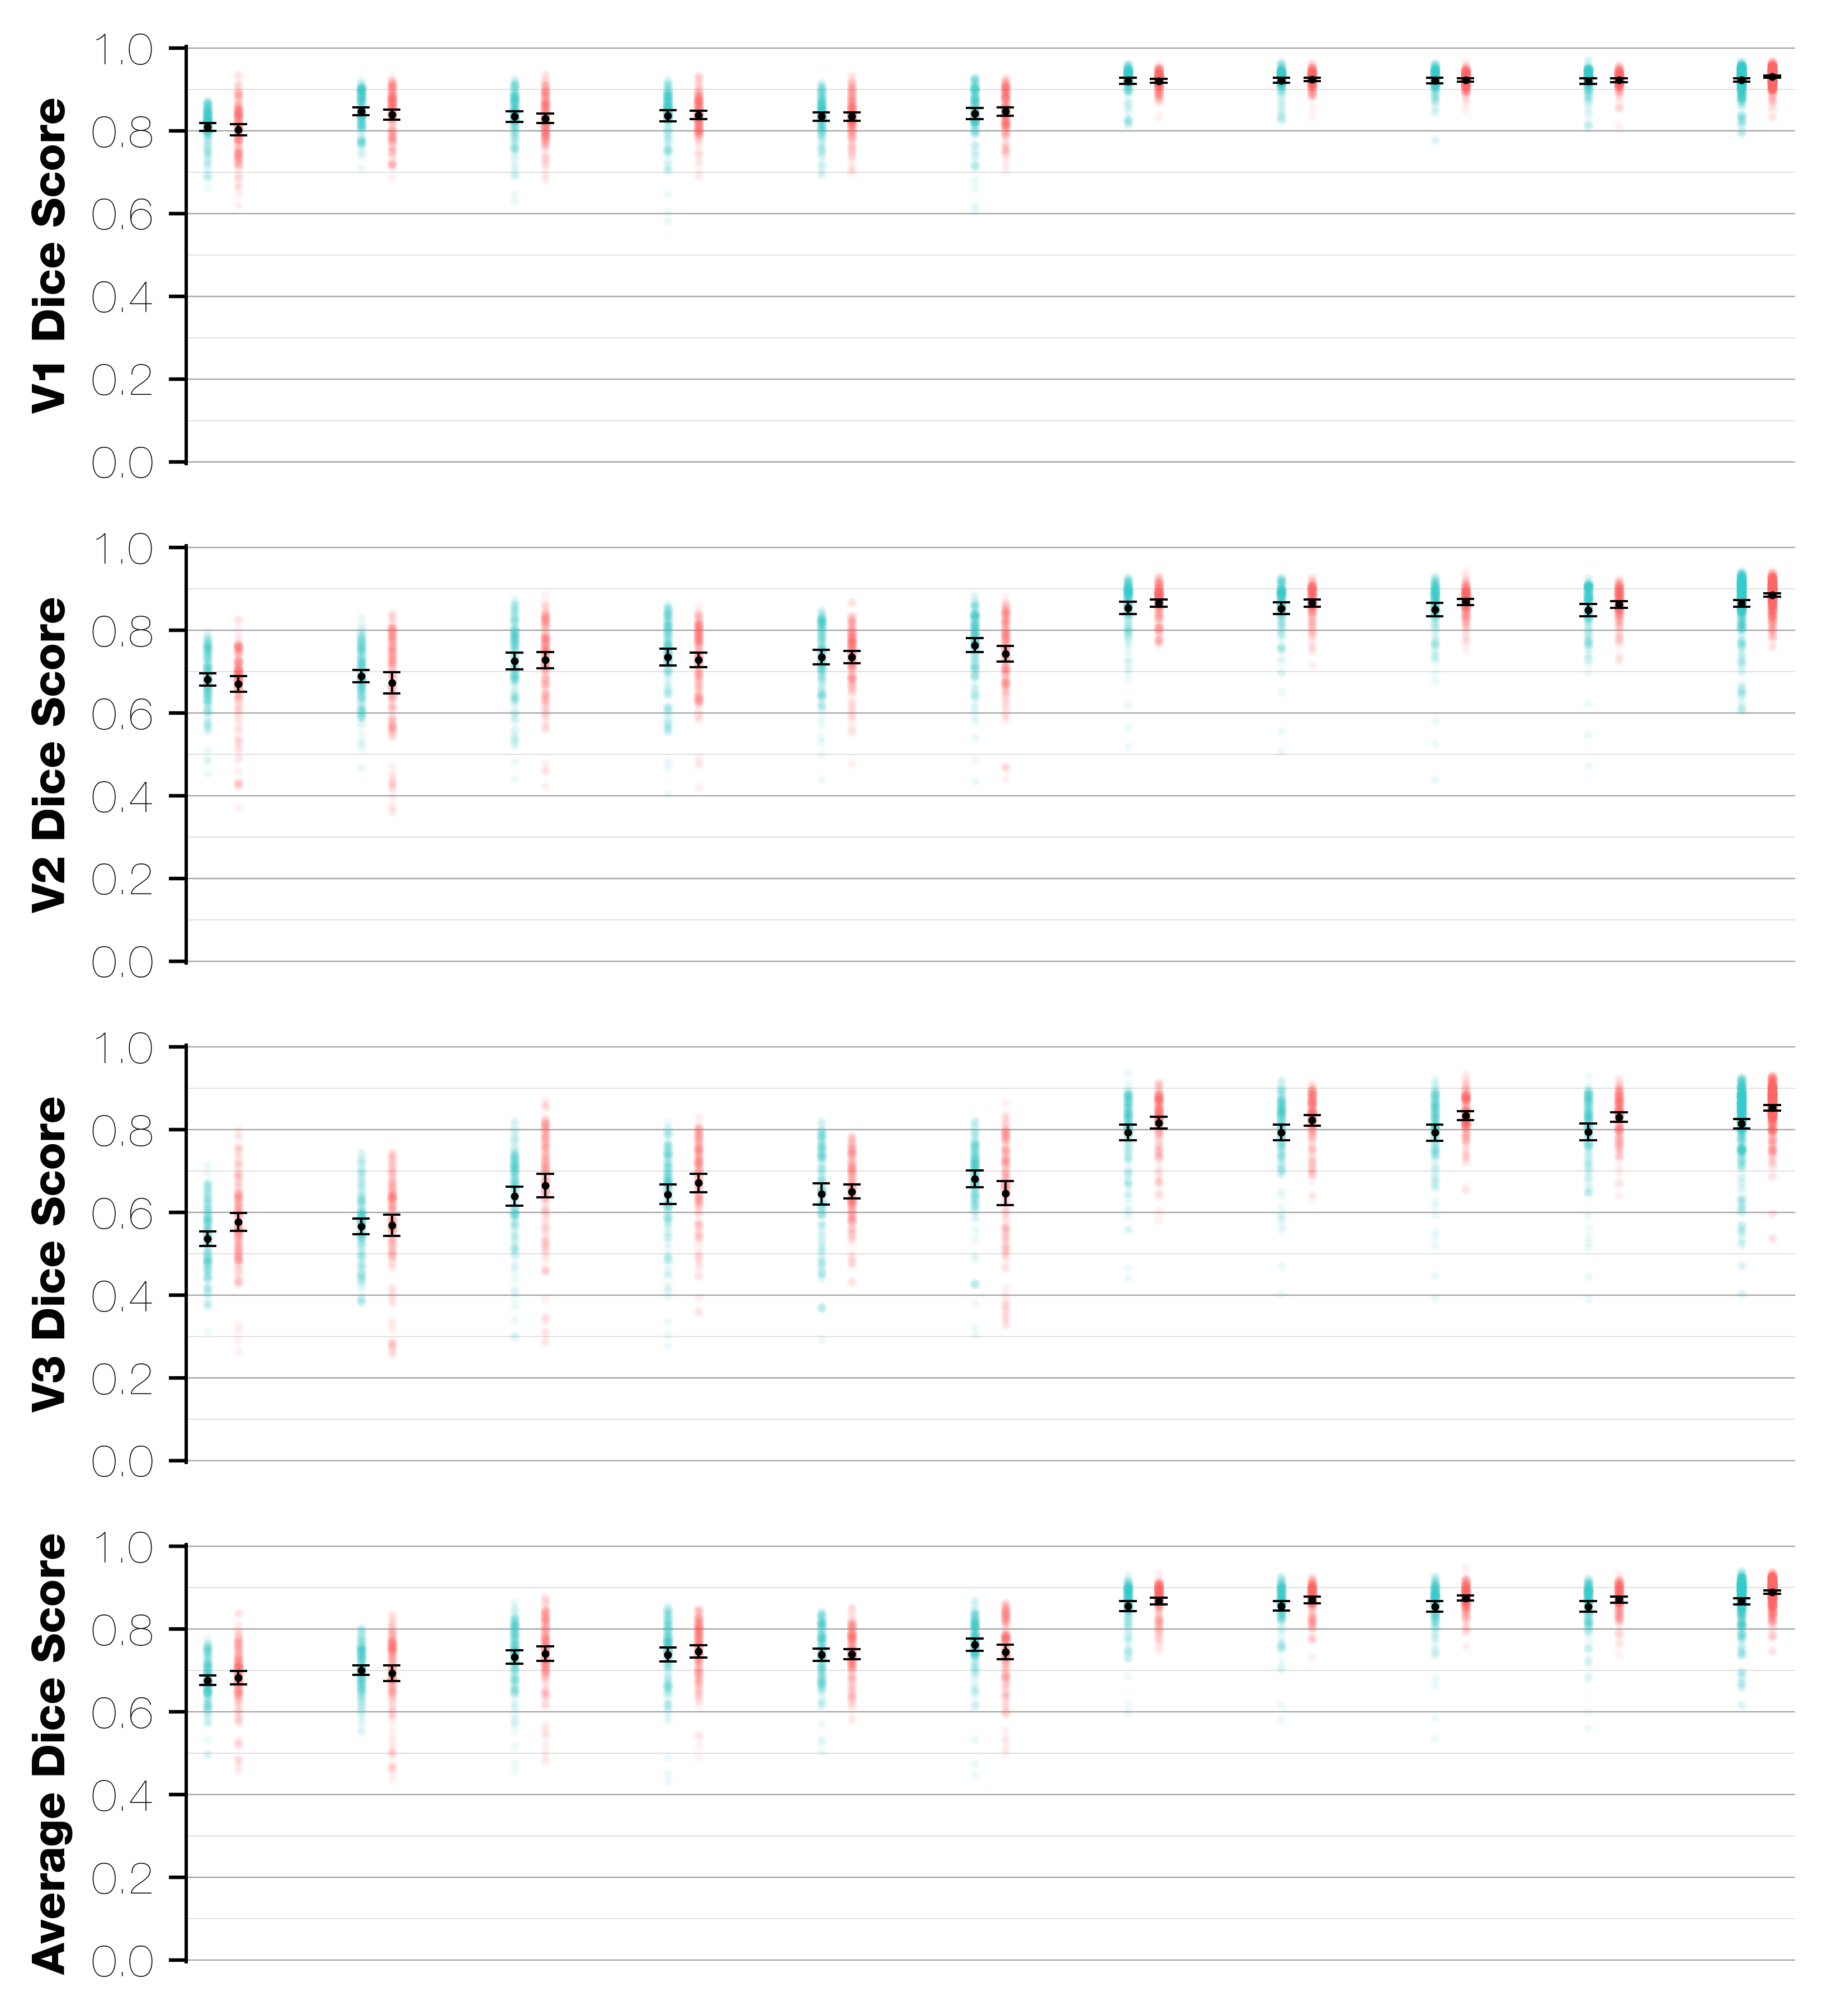

In [10]:
colwidth = 1
lrspace = 0.2
ebarlw = 0.5
ebarwidth = 0.15
ebaropts = dict(middle='mean', extent='ste',
                #middle='median', extent='iqr',
                fw=0.05, lw=0.5, ms=1.5)
pointms = 2.5
ebarclr = {'lh':'k', 'rh':'k'}
pointclr = {'lh': (0.2, 0.8, 0.8), 'rh': (1.0, 0.4, 0.4)}

yticks = np.linspace(0,1,6)

df0 = evals
df0 = df0[np.isin(df0['label'], output_labels)]
rois = np.unique(df0['label'].values)
nrois = len(rois)
#mdls = np.unique(df0['model'].values)
mdls = [k for k in model_trs.keys() if k not in ('null','tmpl','warp')]
mdls = ['tmpl','warp'] + mdls
nmdls = len(mdls)

# We want to perform Bonferroni correction on the confidence intervals we report,
# so we count up the number of confidence intervals we are displaying. This is
# the number of models times the number of hemispheres (2).
bfcount = 2 * nmdls

(fig,axs) = plt.subplots(nrois, 1, figsize=(5,nrois*1.5), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0.1,0.15)

for (roi,ax) in zip(rois, axs):
    df1 = df0[df0['label'] == roi]
    # We don't use spines.
    for sp in ax.spines.values():
        sp.set_visible(False)
    # We do use ticks.
    ax.set_ylim([-0.025, 1.025])
    ax.set_yticks(yticks)
    # We draw our own y-axis vertical bar.
    ax.set_xlim([-0.25, 0.25 + (nmdls-1)*colwidth])
    ax.plot([-0.25,-0.25], [0,1], 'k-', zorder=-99)
    # Plot some mesh lines.
    for y in yticks:
        ax.plot([-0.25, 0.25 + (nmdls-1)*colwidth], [y, y], '-',
                lw=0.3, c='0.65', zorder=-100)
    for y in np.mean([yticks[:-1], yticks[1:]], 0):
        ax.plot([-0.25, 0.25 + (nmdls-1)*colwidth], [y, y], '-',
                lw=0.2, c='0.85', zorder=-100)
    # Specify the labels and xticks.
    if roi[-1] == '_':
        ax.set_ylabel("Average Dice Score")
    else:
        ax.set_ylabel(f'{roi} Dice Score')
    ax.set_xlabel(None)
    ax.set_xticks([])
    # Plot the lh and rh data side-by-side.
    for (h,dx) in zip(['lh','rh'], [-lrspace/2, lrspace/2]):
        df2 = df1[df1['hemisphere'] == h]
        # We want to go through each model in the dataframe.
        for (mdl,x) in zip(mdls, np.arange(nmdls)*colwidth + dx):
            df3 = df2[df2['model'] == mdl]
            if len(df3) == 0:
                continue
            ys = df3['score'].values
            if roi == 'V_':
                (mn,mu,mx) = va.plot.summarize_dist(ys, extent='ste', bfcount=bfcount)
                assert np.abs((mx-mu) - (mu-mn)) < 0.00001
                print(roi, h, mdl, mu, '±', (mx-mu))
            va.plot.plot_distbars(x, ys, axes=ax,
                                  lc=ebarclr[h], mc=ebarclr[h], zorder=2,
                                  bfcount=bfcount,
                                  **ebaropts)
            ax.plot([x]*len(ys), ys, '.', ms=pointms, c=pointclr[h],
                    alpha=0.05, zorder=1)
    # If this is the final set of axes, we want to add some labels

plt.savefig(f'/data/visual-autolabel/figures/summary_{outputs}.pdf',
            bbox_inches='tight',
            transparent=True)

#### Plot a Flatmap with a Rater's Labels

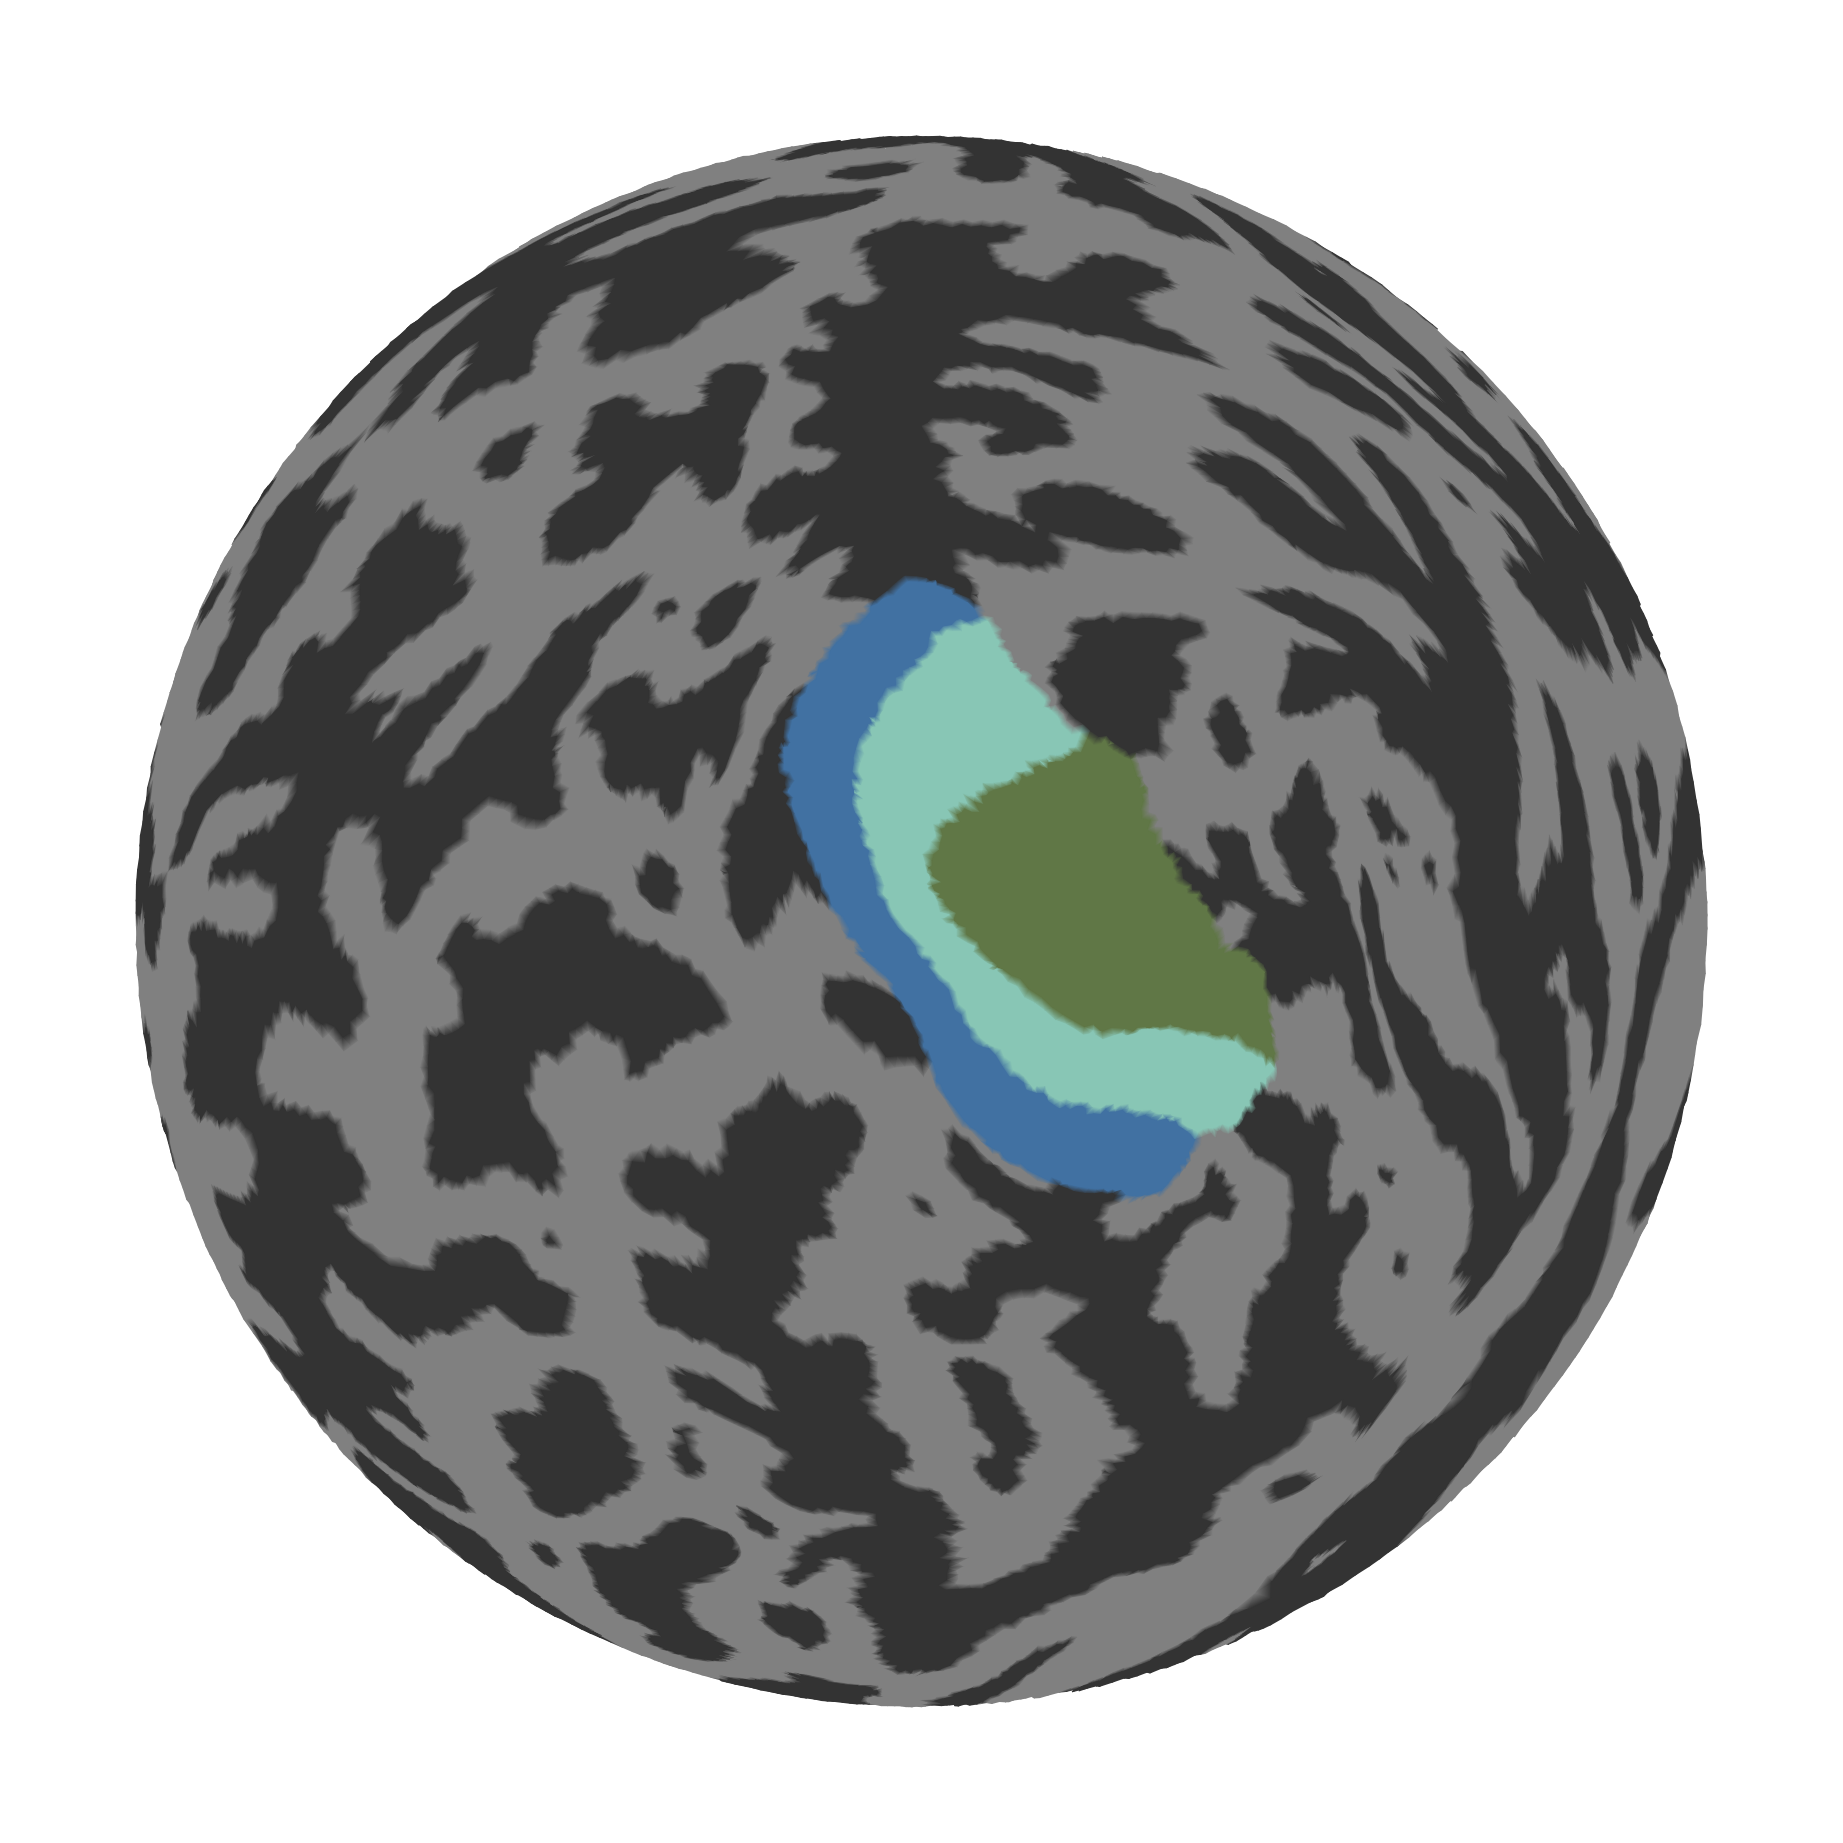

In [24]:
plot_sid = 115017
plot_hem = 'lh'

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0,0)

cm_area = mpl.colors.LinearSegmentedColormap.from_list(
    'visual_area',
    [(0, (1,1,1,0)),
     (0.33, "#DF5F6F"),
     (0.67, "#218331"),
     (1.00, "#66CCEE")]
)
cm_ring = mpl.colors.LinearSegmentedColormap.from_list(
    'visual_area',
    [(0, (1,1,1,0)),
     (0.2, "#DF5F6F"),
     (0.4, "#218331"),
     (0.6, "#66CCEE"),
     (0.8, "#CCBB44"),
     (1.0, "#4171A2")]
)


if outputs == 'ring':
    plot_clr = 'anat_visual_ring'
    plot_cmap = cm_ring
else:
    plot_clr = 'A1_visual_area'
    plot_cmap = cm_area

plot_fmap = valmaps[plot_sid][0 if plot_hem == 'lh' else 1]
ny.cortex_plot(
    plot_fmap,
    color=plot_clr,
    axes=ax,
    mask=('A1_visual_area', (1,2,3)),
    cmap=plot_cmap)

ax.axis('off')

pass

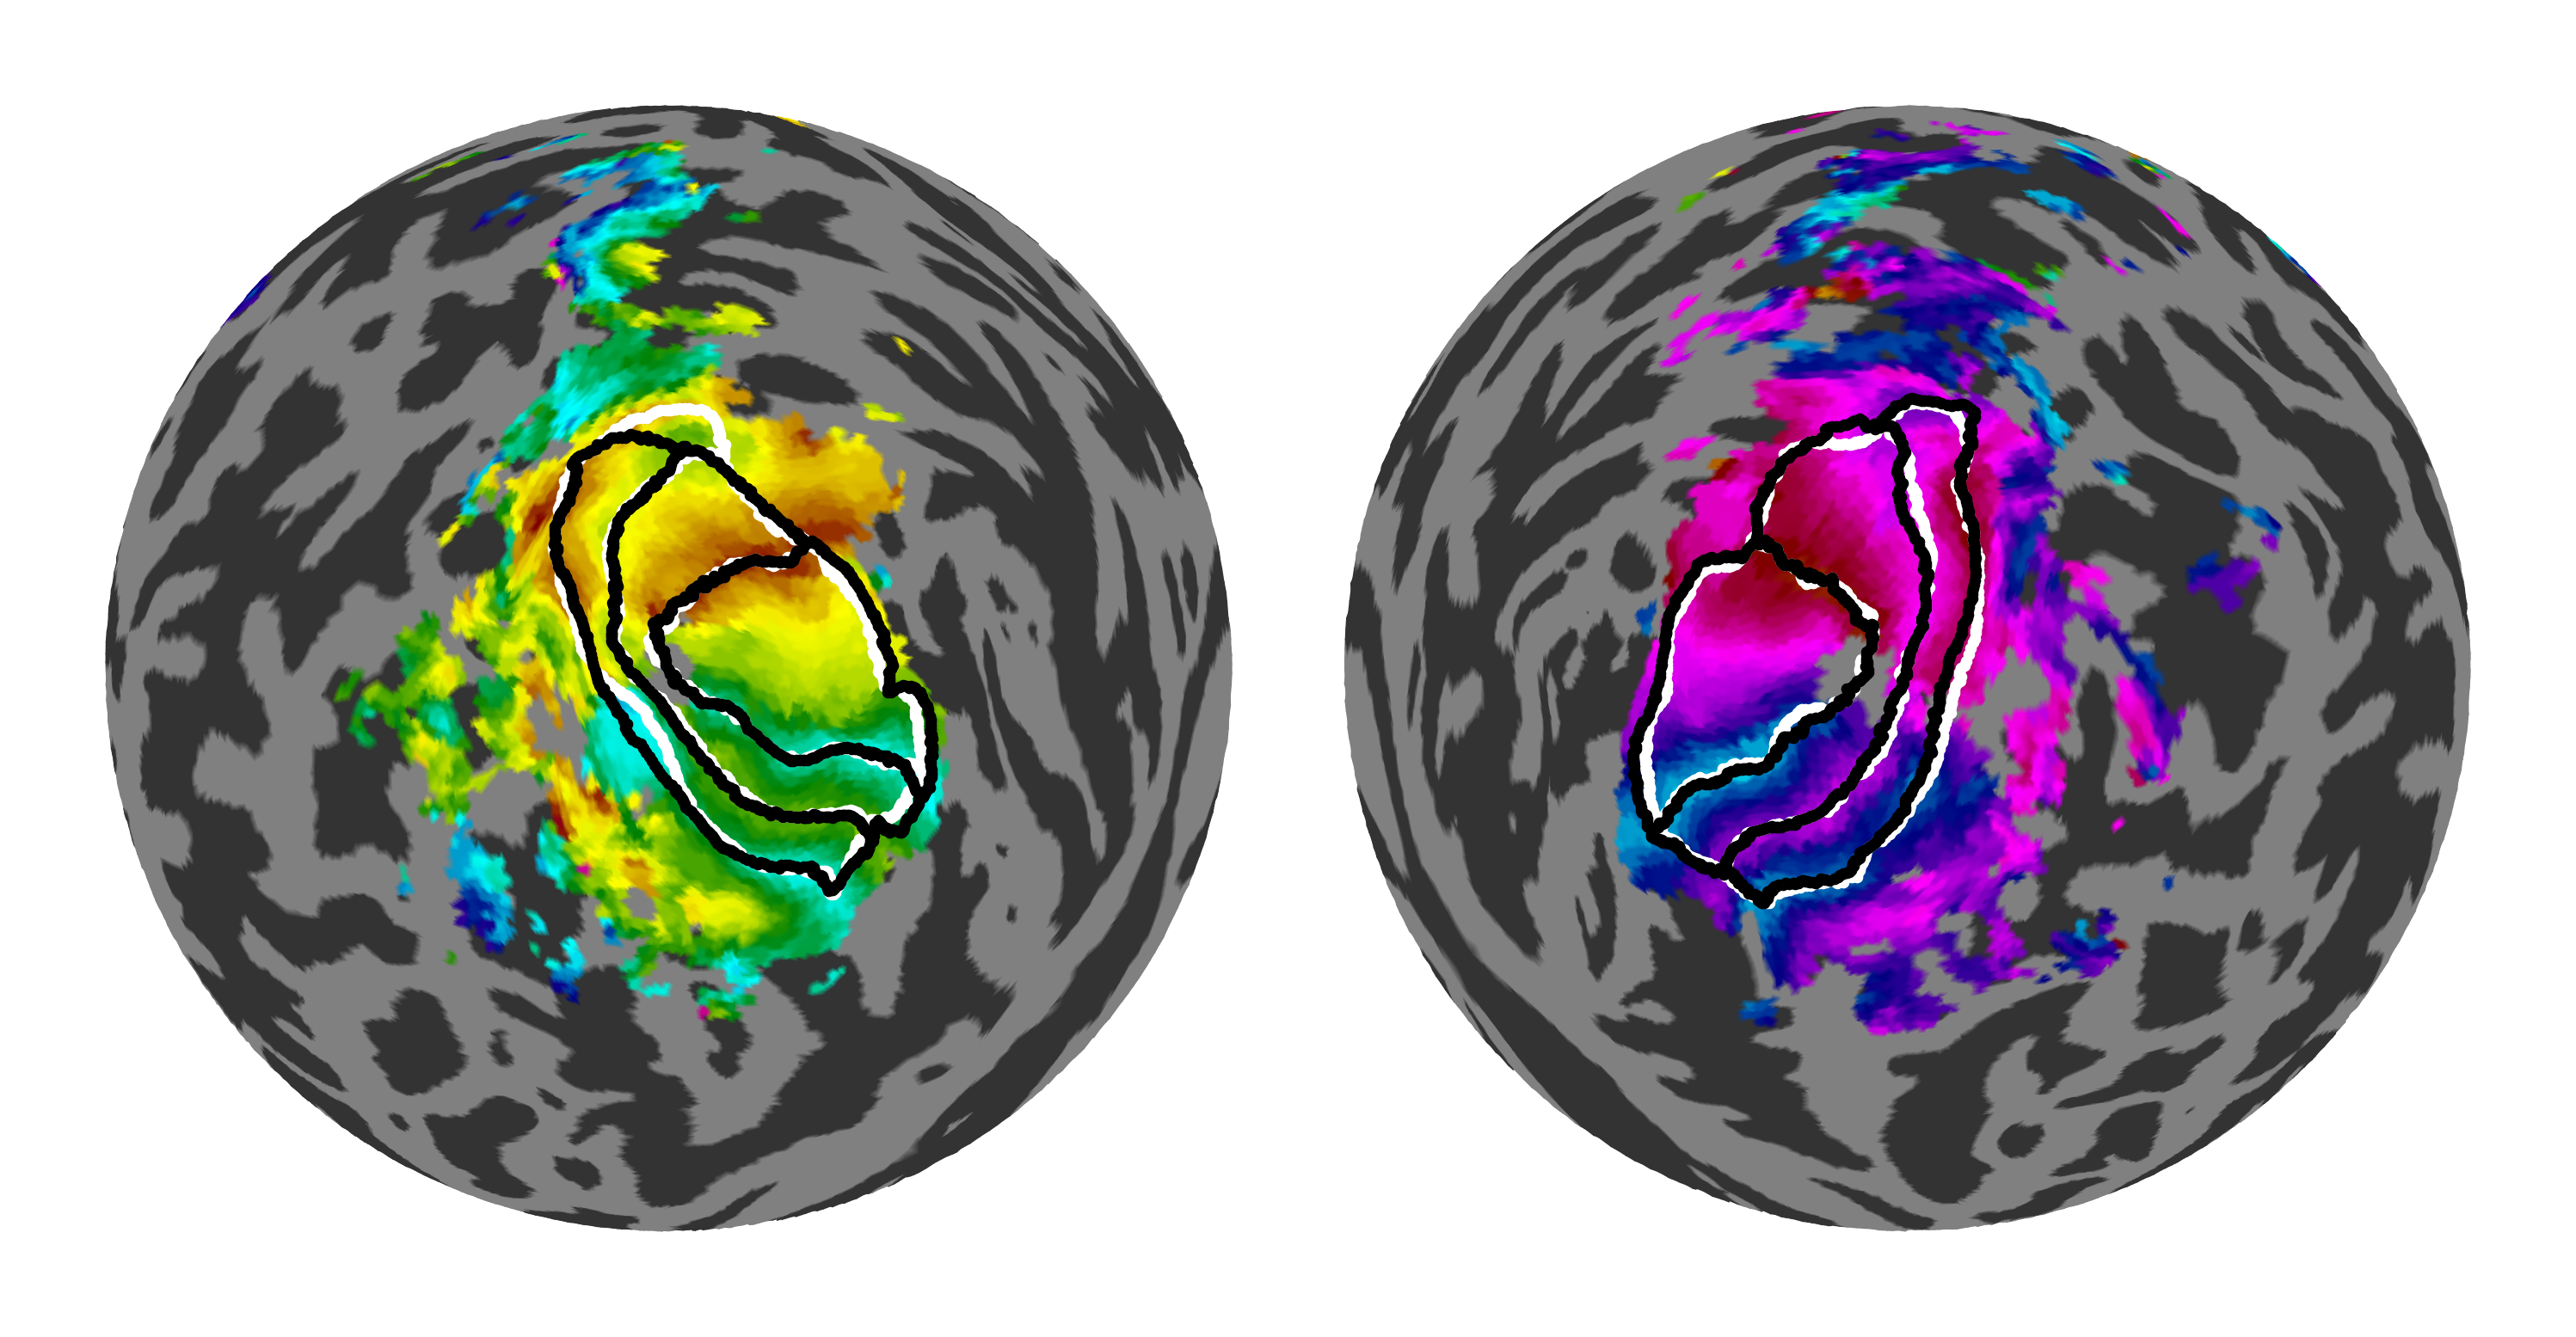

In [37]:
sid = 115017
rater = 'A1'
#prefix = 'func'
#prefix = 'anat'
#prefix = 'tmpl'
prefix = 'A2'

dpi = 72*8
(fig,axs) = plt.subplots(1,2, figsize=(5, 2.5), dpi=dpi)
fig.subplots_adjust(0,0,1,1,0,0)

for (h,hii,ax) in zip(['lh','rh'], [0,1], axs):
    fmap = valmaps[sid][hii]
    if outputs == 'area':
        fmapclr = 'prf_polar_angle'
    else:
        fmapclr = 'prf_eccentricity'
    ny.cortex_plot(fmap, axes=ax, color=fmapclr,
                   mask=('prf_variance_explained', 0.1, 1))
    # Add lines.
    for (pre,clr) in zip([rater, prefix], ['w', 'k']):
        if pre == 'tmpl':
            pre = 'prior'
        elif pre == 'warp':
            pre = 'inf'
        pnm = f'{pre}_visual_{outputs}'
        p = fmap.prop(pnm)
        (u,v) = fmap.tess.indexed_edges
        ii = p[u] != p[v]
        xy = fmap.coordinates
        xy = np.mean([xy[:,u[ii]], xy[:,v[ii]]], axis=0)
        ax.scatter(xy[0],xy[1], c=clr, s=0.5)
    # Turn off axes.
    ax.axis('off')

plt.savefig(f'/data/visual-autolabel/figures/sample-contours_{sid}_{outputs}_{prefix}.png',
            bbox_inches='tight',
            dpi=dpi)

### Hyperparameter Search

In [47]:
def load_cell(cell_path):
    """Loads the meta-data for one cell of the grid.
    
    `load_cell(path)` loads the cell at the given `path`, which should be a
    directory containing the `opts.json`, `plan.json`, and `run.log` files.
    """
    from pathlib import Path
    cell_path = Path(cell_path)
    with (cell_path / 'opts.json').open('rt') as fl:
        opts = json.load(fl)
    opts = dict({'cell_id': int(opts['model_key'][4:])}, **opts)
    with (cell_path / 'plan.json').open('rt') as fl:
        plan = json.load(fl)
    for (ii,p) in enumerate(plan):
        for (k,v) in p.items():
            opts[f'{k}_{ii}'] = v
    with (cell_path / 'run.log').open('rt') as fl:
        log = fl.readlines()
    return log

In [61]:
from pathlib import Path
grid_path = Path('/data/visual-autolabel/grid/cells')
log = load_cell(grid_path / 'grid00111')
#min([float(ln.split()[9]) for ln in log if ln.endswith('*\n')])
it0s = [ii for (ii,ln) in enumerate(log) if ln.startswith('Iteration')]
it0s.append(-1)
bests = [
    min([float(ln.split()[9]) for ln in log[ii0:ii1] if ln.endswith('*\n')])
    for (ii0,ii1) in zip(it0s[:-1], it0s[1:])]
bests

[0.084, 0.09]

In [18]:
from pathlib import Path
grid_path = Path('/data/visual-autolabel/grid/cells')

def load_cell(cell_path): 
    """Loads the meta-data for one cell of the grid.
    
    `load_cell(path)` loads the cell at the given `path`, which should be a
    directory containing the `opts.json`, `plan.json`, and `run.log` files.
    """
    from pathlib import Path
    cell_path = Path(cell_path)
    with (cell_path / 'opts.json').open('rt') as fl:
        opts = json.load(fl)
    opts = dict({'cell_id': int(opts['model_key'][4:])}, **opts)
    with (cell_path / 'plan.json').open('rt') as fl:
        plan = json.load(fl)
    for (ii,p) in enumerate(plan):
        for (k,v) in p.items():
            opts[f'{k}_{ii}'] = v
    with (cell_path / 'run.log').open('rt') as fl:
        log = fl.readlines()
    it0s = [ii for (ii,ln) in enumerate(log) if ln.startswith('Iteration')]
    it0s.append(-1)
    losses = np.array(
        [min([float(ln.split()[9])
              for ln in log[ii0:ii1]
              if ln.endswith('*\n')])
         for (ii0,ii1) in zip(it0s[:-1], it0s[1:])])
    if len(losses) > 0:
        opts['loss_mean'] = np.mean(losses)
        opts['loss_median'] = np.median(losses)
        opts['loss_std'] = np.std(losses)
        opts['loss_max'] = np.max(losses)
        opts['loss_min'] = np.min(losses)
    else:
        opts['loss_mean'] = np.nan
        opts['loss_median'] = np.nan
        opts['loss_std'] = np.nan
        opts['loss_max'] = np.nan
        opts['loss_min'] = np.nan
    opts['partition'] = va.partition_id(opts['partition'])
    return opts

cells = []
for k in range(1800):
    try:
        cell = load_cell(grid_path / f'grid{k:05d}')
    except Exception as err:
        print(f"ERROR {k}: {err}")
        continue
    cells.append(cell)
cells_full = pandas.DataFrame(cells)
cells = cells_full.drop(
    columns=[
        'pretrained', 'multiproc', 
        'model_cache_path', 'data_cache_path',
        'model_key', 'partition',
        'lr_1', 'lr_2', 'bce_weight_1', 'bce_weight_2'])
cells = cells.rename(columns=dict(lr_0='lr', bce_weight_0='bce_weight'))
################################################################################

In [19]:
variates = []
for c in cells.columns:
    if 'loss' in c:
        continue
    if c.endswith('_1') or c.endswith('_2'):
        continue
    if c in ('until', 'model_key', 'cell_id'):
        continue
    if len(np.unique(cells[c].values)) > 1:
        variates.append(c)
variates = {k: np.unique(cells[k]) for k in variates}

def cellselect(cells, col='loss_min', variates=variates, **kw):
    df = cells
    srt = []
    for (k,v) in kw.items():
        if v is None:
            srt.append(k)
        else:
            df = df[df[k] == v]
    df = df.sort_values(srt)
    for k in srt:
        vs = variates[k]
        
    shape = [len(np.unique(df[k].values)) for k in srt]
    return np.reshape(df[col].values, shape)

variates

{'base_model': array(['resnet18', 'resnet34'], dtype=object),
 'gamma': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'batch_size': array([2, 4, 6]),
 'inputs': array(['anat', 'full'], dtype=object),
 'prediction': array(['area', 'ring'], dtype=object),
 'lr': array([0.00167, 0.0025 , 0.00375, 0.00562, 0.00844]),
 'bce_weight': array([0.5 , 0.67, 0.75])}

In [20]:
def plotgrid(cells, inputs, outputs, base_model, col='loss_min',
             vmin=0, vmax=0.2, cmap='cividis',
             figsize=(7,7), dpi=512,
             gammas=(0.8, 0.85, 0.9, 0.95, 1),
             lrs=(0.00167, 0.0025 , 0.00375, 0.00562, 0.00844),
             axes=None,
             star=True):
    from warnings import warn
    # First get the set of cells we are planning to use:
    cells = cells[(cells['inputs'] == inputs) & (cells['prediction'] == outputs)]
    cells = cells[cells['base_model'] == base_model]
    # We now need a grid of 3 x 3 matrices, each of which will be 5x5:
    if axes is None:
        (fig,axs) = plt.subplots(3, 3, dpi=dpi, figsize=figsize, sharex=True, sharey=True)
    else:
        axs = axes
        fig = None
    posmin = None
    totmin = np.inf
    mtcs = []
    for (axrow,batch_size) in zip(axs, [2,4,6]):
        subcells0 = cells[cells['batch_size'] == batch_size]
        mtxrow = []
        for (ax, bcew0) in zip(axrow, [0.5, 0.67, 0.75]):
            # Get the subset of cells that match:
            subcells = subcells0[subcells0['bce_weight'] == bcew0]
            # Now go through and make the matrix (there may be values missing, so we
            # build this up iteratively).
            mtx = []
            g = []
            l = []
            for gamma in gammas:
                row = []
                for lr in lrs:
                    g.append(gamma)
                    l.append(lr)
                    cell = subcells[(subcells['gamma'] == gamma) & (subcells['lr'] == lr)]
                    if len(cell) == 0:
                        warn(f"missing cell: {inputs}/{outputs}/"
                             f"{base_model}/{batch_size}/{bcew0}/{gamma}/{lr}")
                        row.append(np.nan)
                    elif len(cell) > 1:
                        warn(f"identical cells: {[r['cell_id'] for (ii,r) in cell.iterrows()]}")
                        row.append(np.nan)
                    else:
                        row.append(cell[col].values[0])
                mtx.append(row)
            mtx = np.round(np.array(mtx), 3)
            mtcs.append(mtx)
            ax.imshow(mtx, vmin=vmin, vmax=vmax, cmap=cmap)
            ax.invert_yaxis()
            ax.set_title(f'batch={batch_size}, BCE$_0$={bcew0}')
            # We want to track the smallest value
            mtxmin_ii = np.nanargmin(mtx)
            mtxmin = mtx.flat[mtxmin_ii]
            if mtxmin < totmin:
                totmin = mtxmin
                posmin = {
                    'batch_size': batch_size, 'bce_weight': bcew0,
                    'gamma': g[mtxmin_ii], 'lr': l[mtxmin_ii],
                    'value': totmin}
    for ax in axs[:,0]:
        ax.set_ylabel('$\gamma$')
        ax.set_yticks(range(len(gammas)))
        ax.set_yticklabels(gammas)
    for ax in axs[-1,:]:
        ax.set_xlabel('Learning Rate [$10^{-3}$]')
        ax.set_xticks(range(len(lrs)))
        ax.set_xticklabels([f'{lr*1000:3.2f}' for lr in lrs])
    if star and np.isfinite(totmin):
        for (ax,mtx) in zip(axs.flat, mtcs):
            for (ri,row) in enumerate(mtx):
                for (ci,val) in enumerate(row):
                    if np.round(val, 3) <= totmin:
                        ax.plot(ci, ri, 'w*', zorder=10)
                        print(ci, ri, np.round(val, 3))
    if fig is not None:
        fig.subplots_adjust(0,0,1,1,0.2,0.2)
    return posmin

2 2 0.159
3 1 0.16
[anat:area]  ResNet18: 0.16;  ResNet34: 0.16


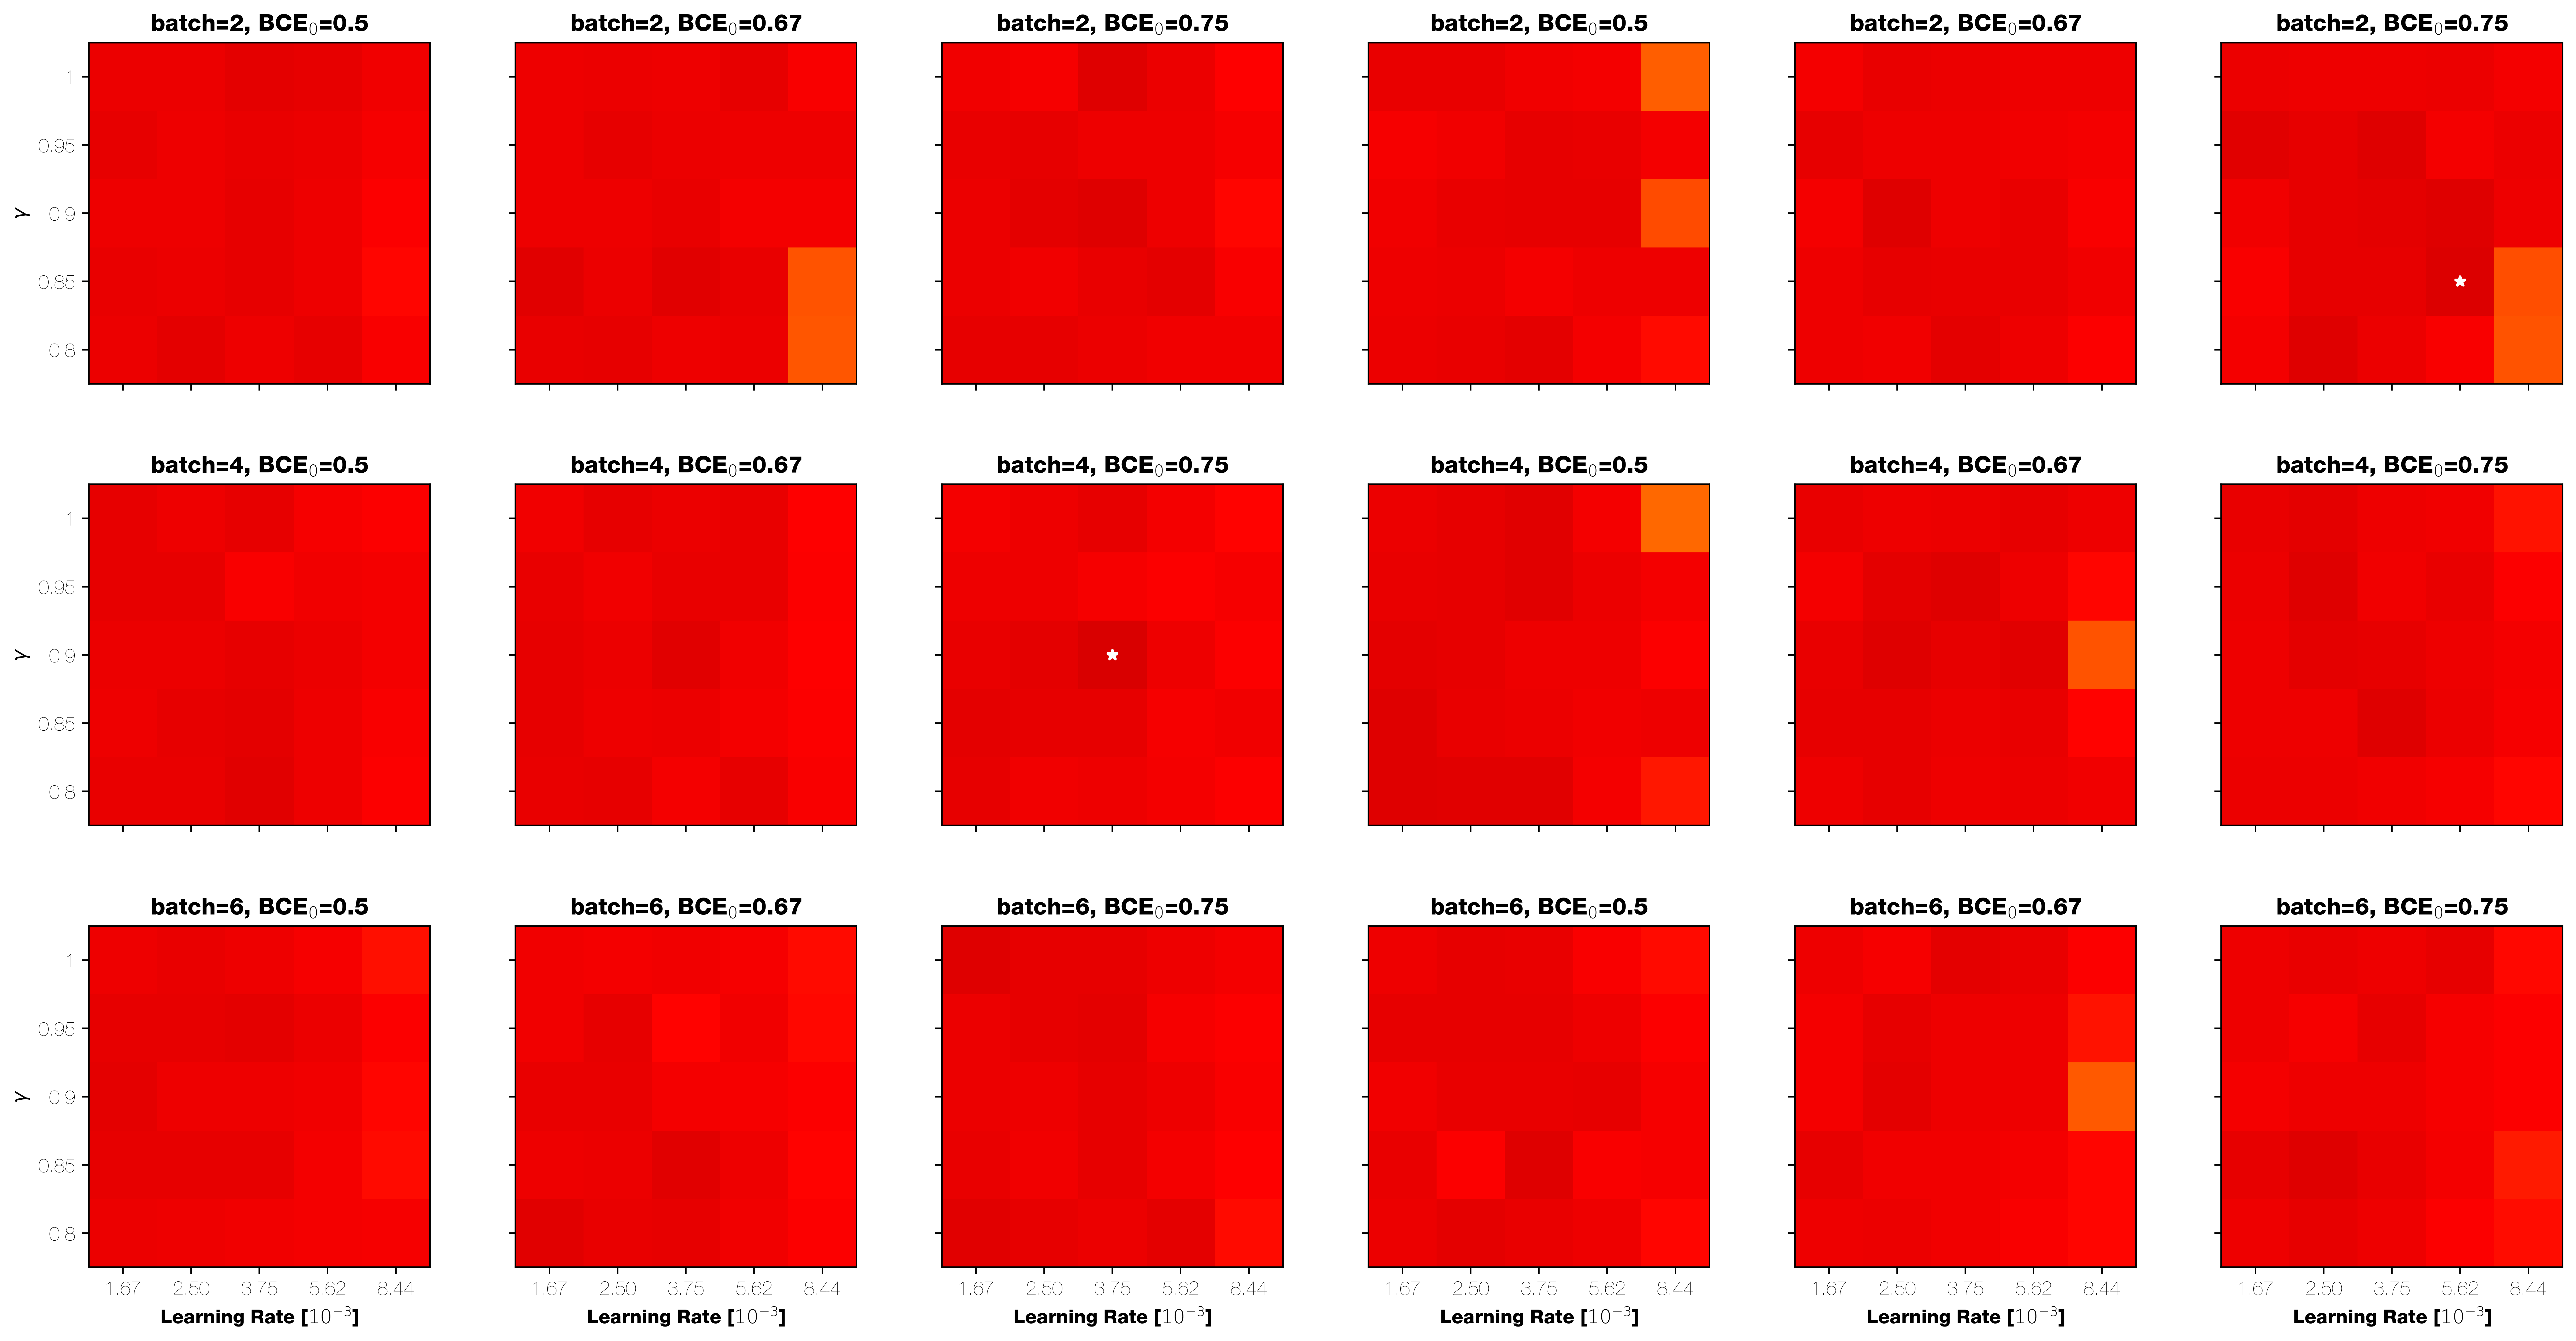

1 4 0.067
2 3 0.067
0 4 0.067
2 2 0.067
0 4 0.067
1 3 0.067
[full:area]  ResNet18: 0.07;  ResNet34: 0.07


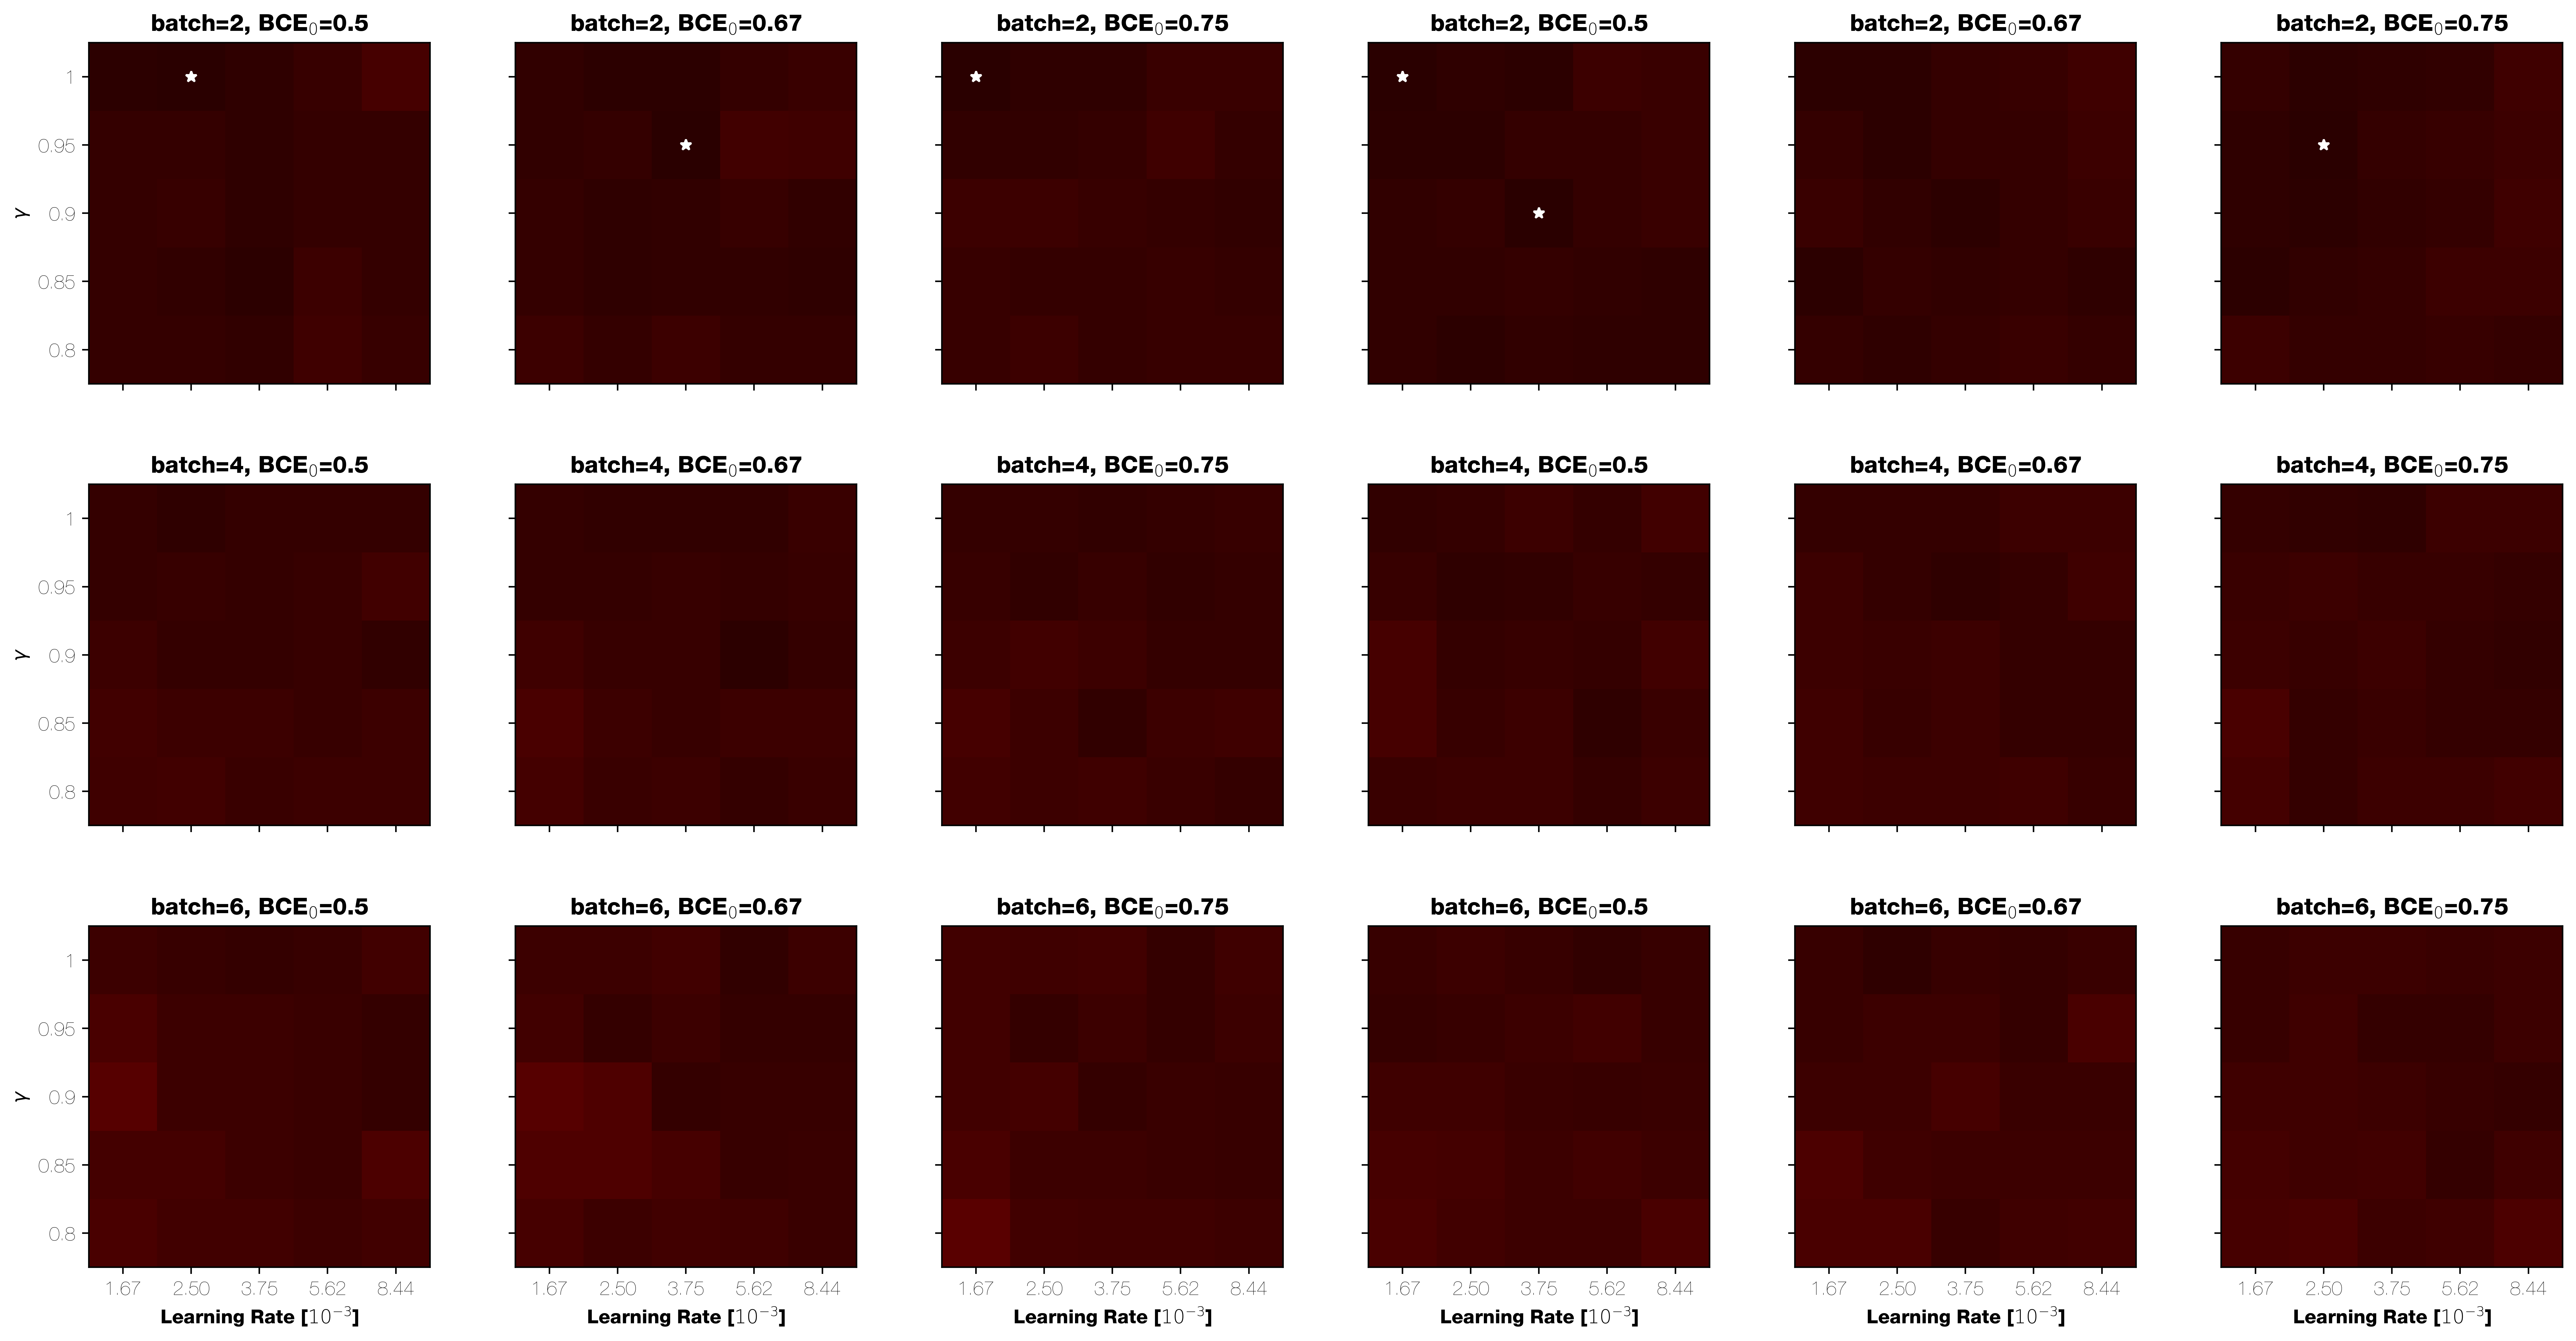

3 2 0.287
1 2 0.288
[anat:ring]  ResNet18: 0.29;  ResNet34: 0.29


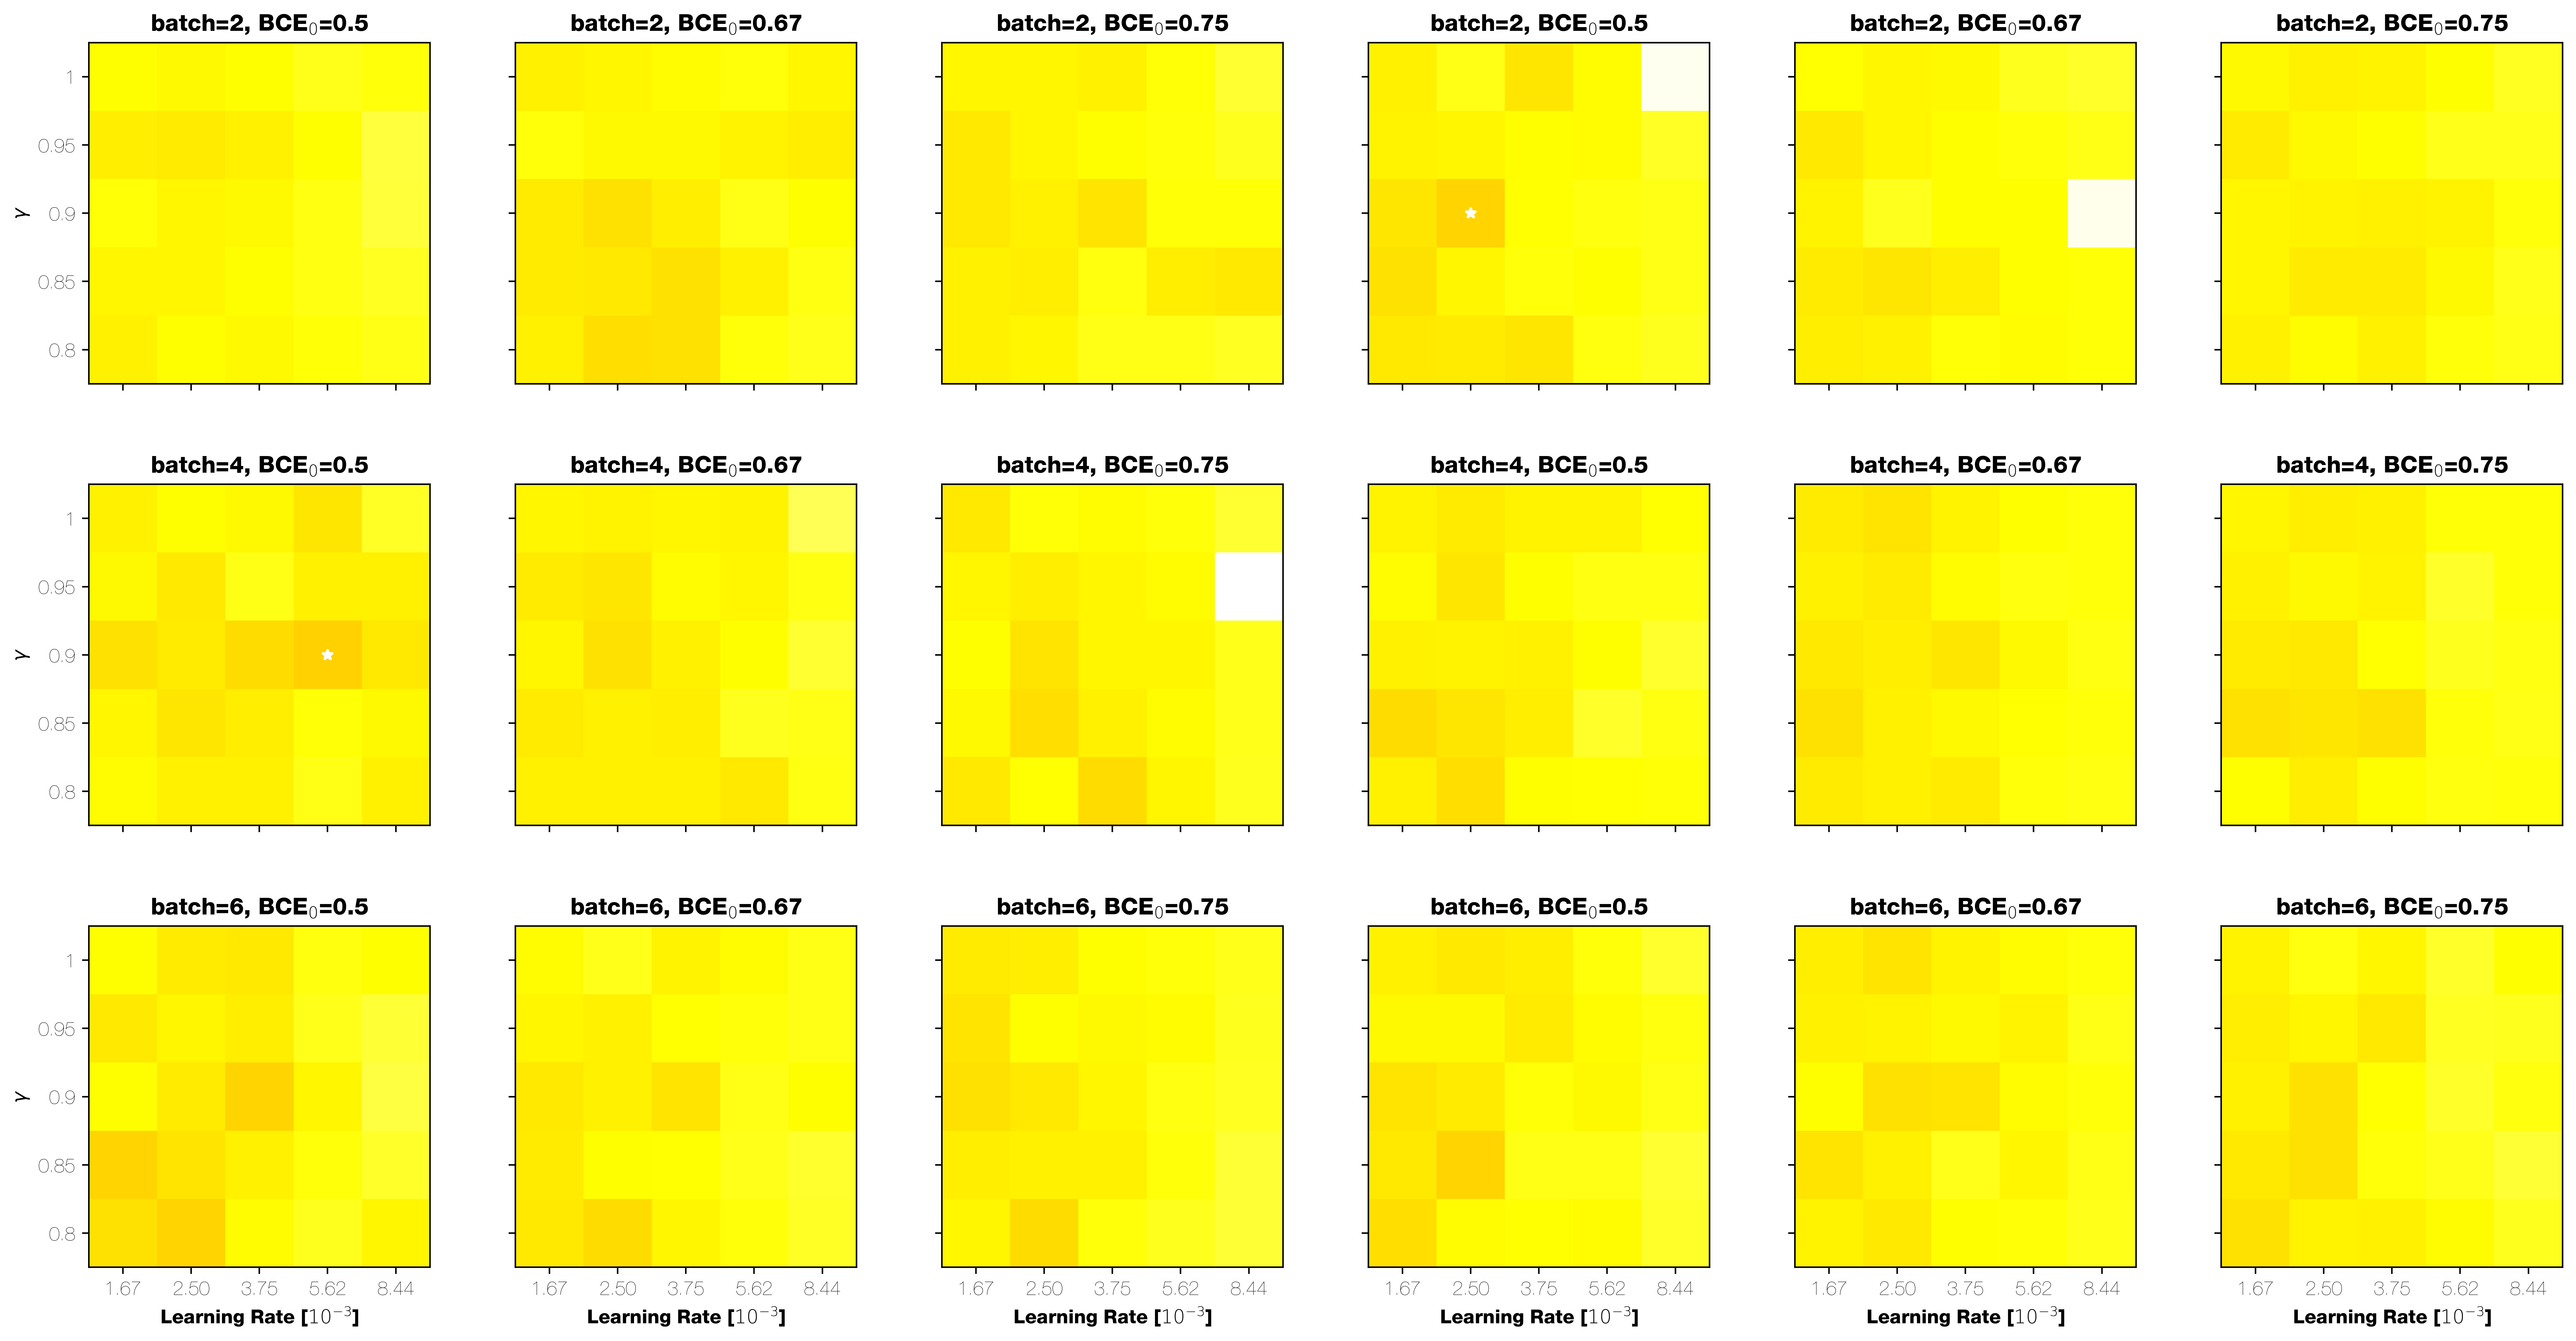

0 3 0.093
2 0 0.095
1 1 0.095
[full:ring]  ResNet18: 0.09;  ResNet34: 0.10


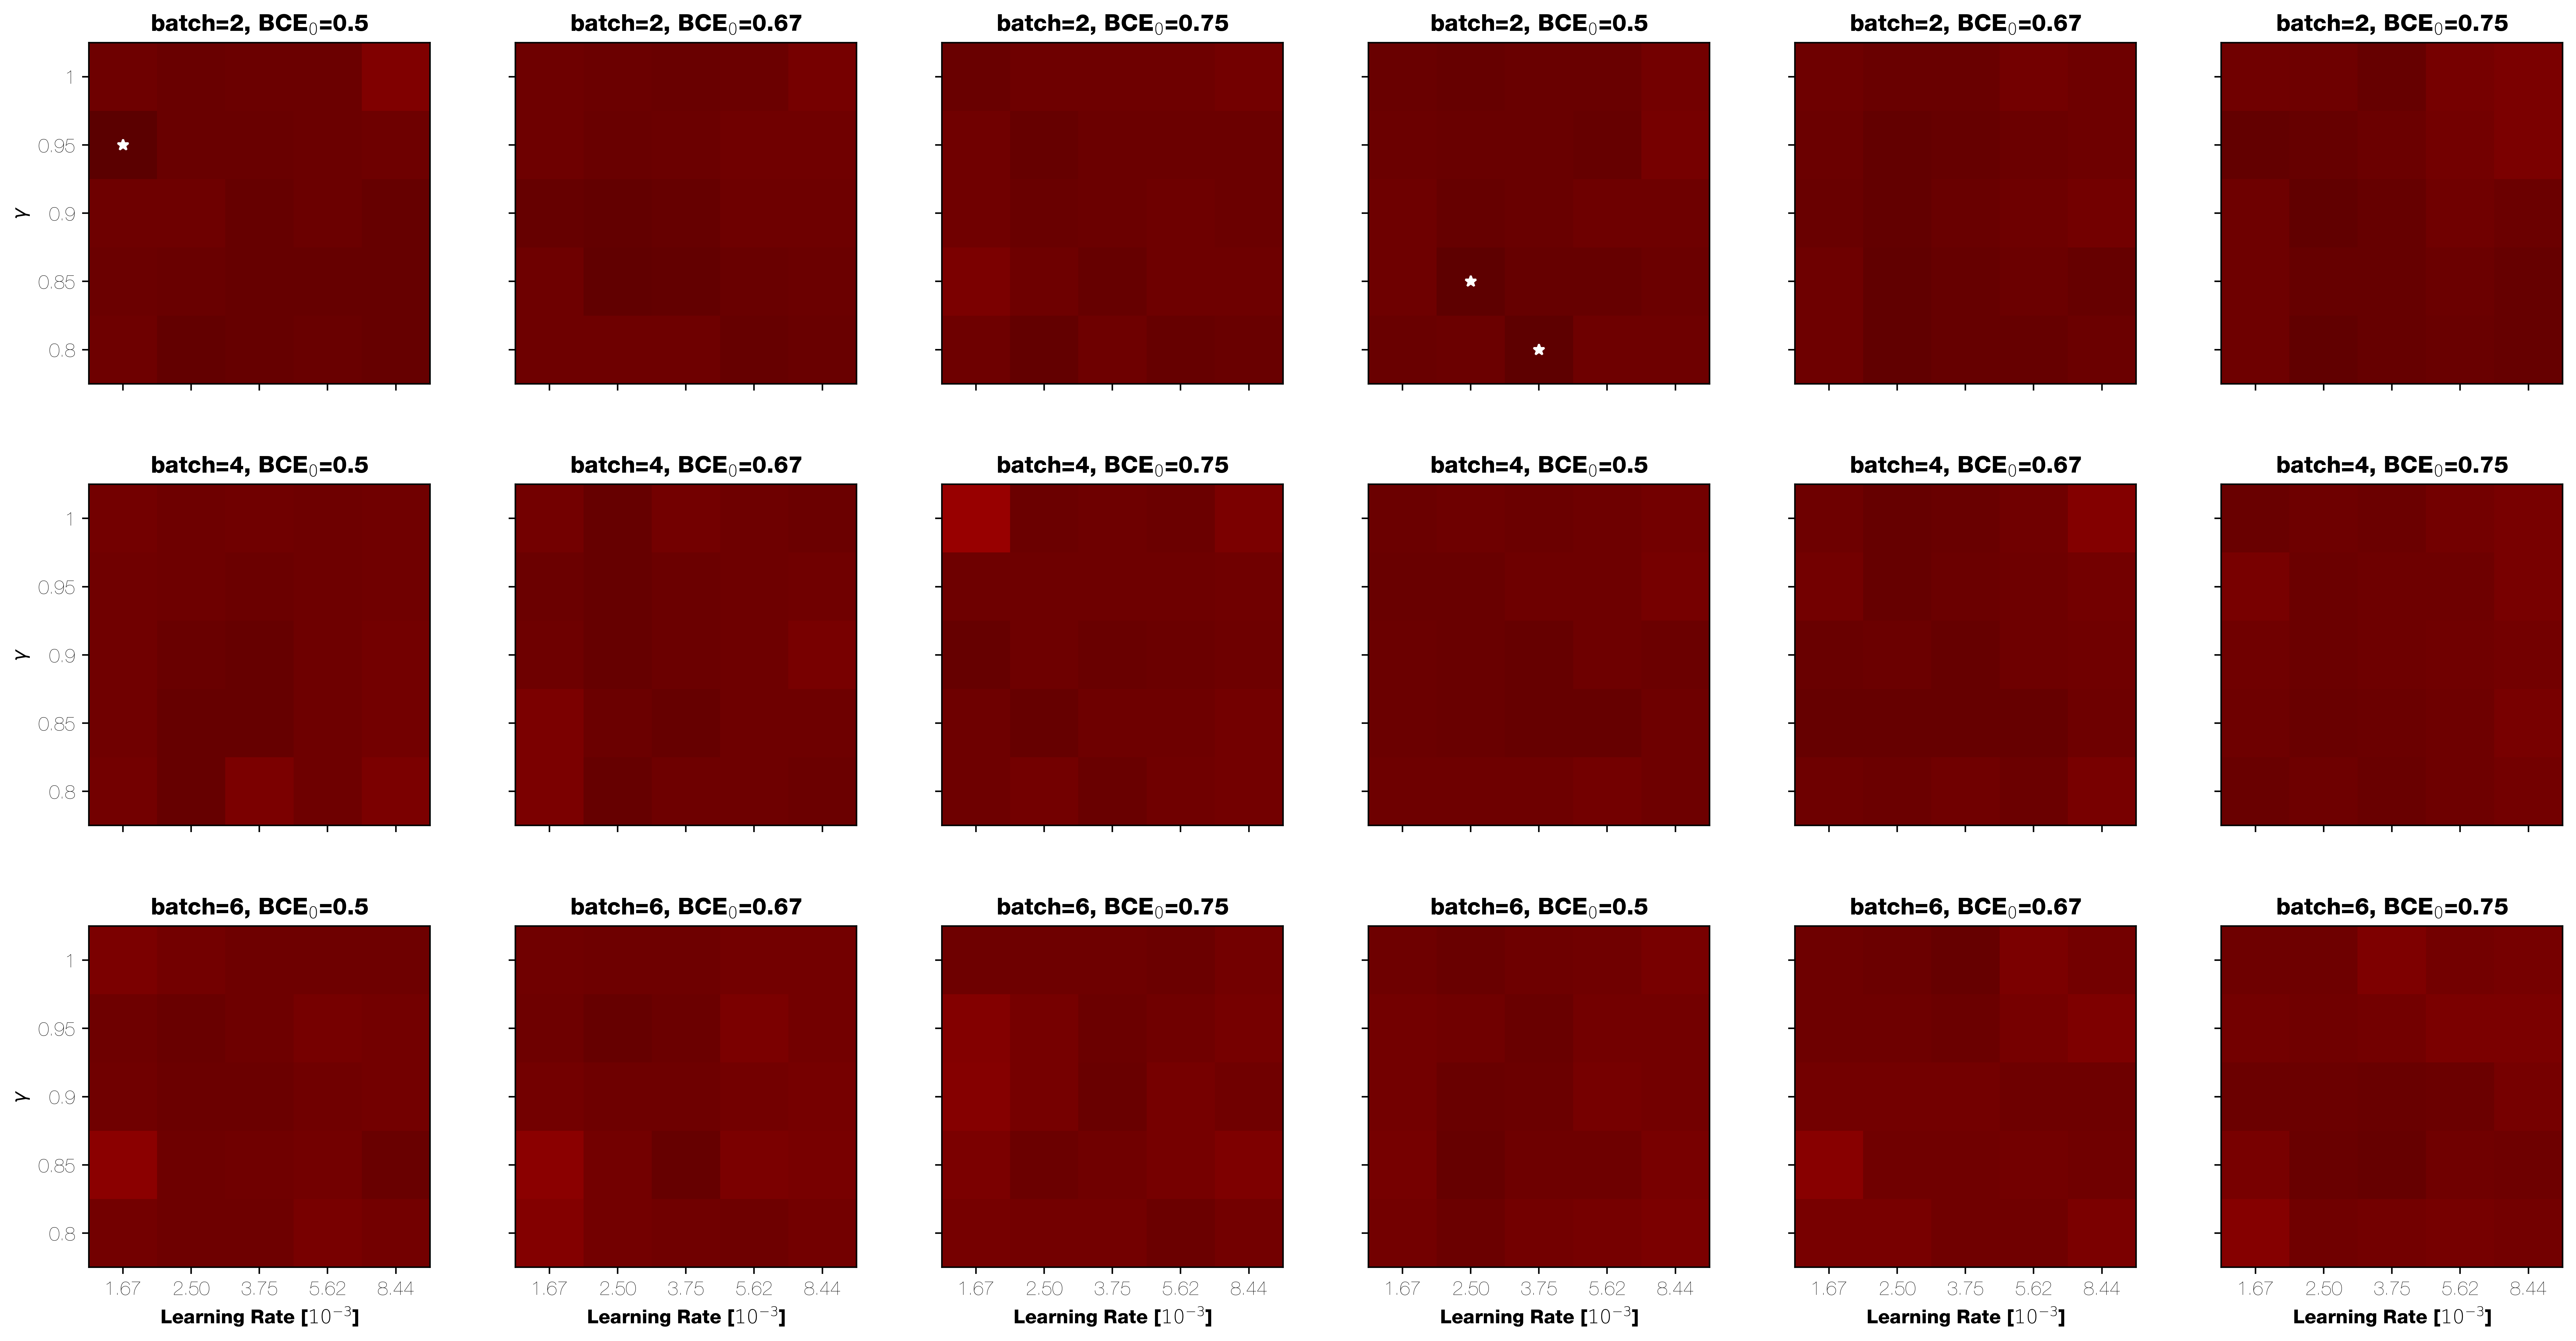

In [21]:
inputs = 'anat'
outputs = 'ring'

kws = {('anat','area'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('full','area'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('anat','ring'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('full','ring'): dict(vmin=0.05, vmax=0.4, cmap='hot')}
for (inputs,outputs) in [('anat','area'),('full','area'),('anat','ring'),('full','ring')]:
    kw = kws[(inputs, outputs)]

    (fig,axs) = plt.subplots(3, 6, figsize=(18,9), dpi=512, sharex=True, sharey=True)
    min18 = plotgrid(cells, inputs, outputs, 'resnet18', axes=axs[:,:3], **kw)
    min34 = plotgrid(cells, inputs, outputs, 'resnet34', axes=axs[:,3:], **kw)
    print(f'[{inputs}:{outputs}]  ResNet18: {min18["value"]:3.2f};  ResNet34: {min34["value"]:3.2f}')
    for ax in axs[:,3]:
        ax.set_ylabel('')

    fig.subplots_adjust(0,0,1,1,0.25,0.25)
    plt.show()

[]

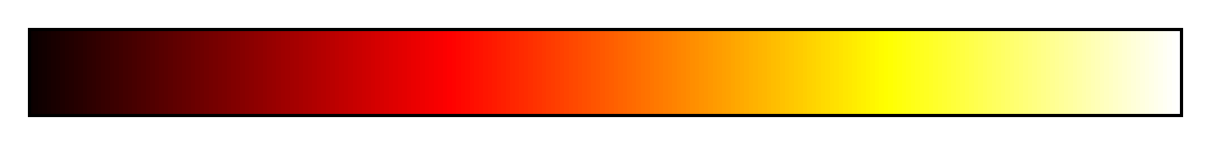

In [78]:

fig = plt.figure(figsize=(5, 0.5))
img = plt.imshow([[0.05,0.3]], cmap="hot")
plt.gca().set_visible(False)
cax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
cax.set_xticks([])
#pl.savefig("colorbar.pdf")

In [79]:
def grid_versus(cells, inputs, outputs, vcol, val1, val2, col='loss_min'):
    # First get the set of cells we are planning to use:
    cells = cells[(cells['inputs'] == inputs) & (cells['prediction'] == outputs)]
    # Now pick out the cells we plan to put on each axes:
    xcells = cells[cells[vcol] == val1]
    ycells = cells[cells[vcol] == val2]
    mergecols = [k for k in ['batch_size', 'bce_weight', 'lr', 'gamma', 'base_model'] if k != vcol]
    # Now align them:
    mcells = xcells.merge(
        ycells,
        on=mergecols,
        how='inner')
    (x,y) = (mcells[col + '_x'].values, mcells[col + '_y'].values)
    return (x,y)

mu(x-y) = -1.791e-3; se(x-y) = +0.420e-3


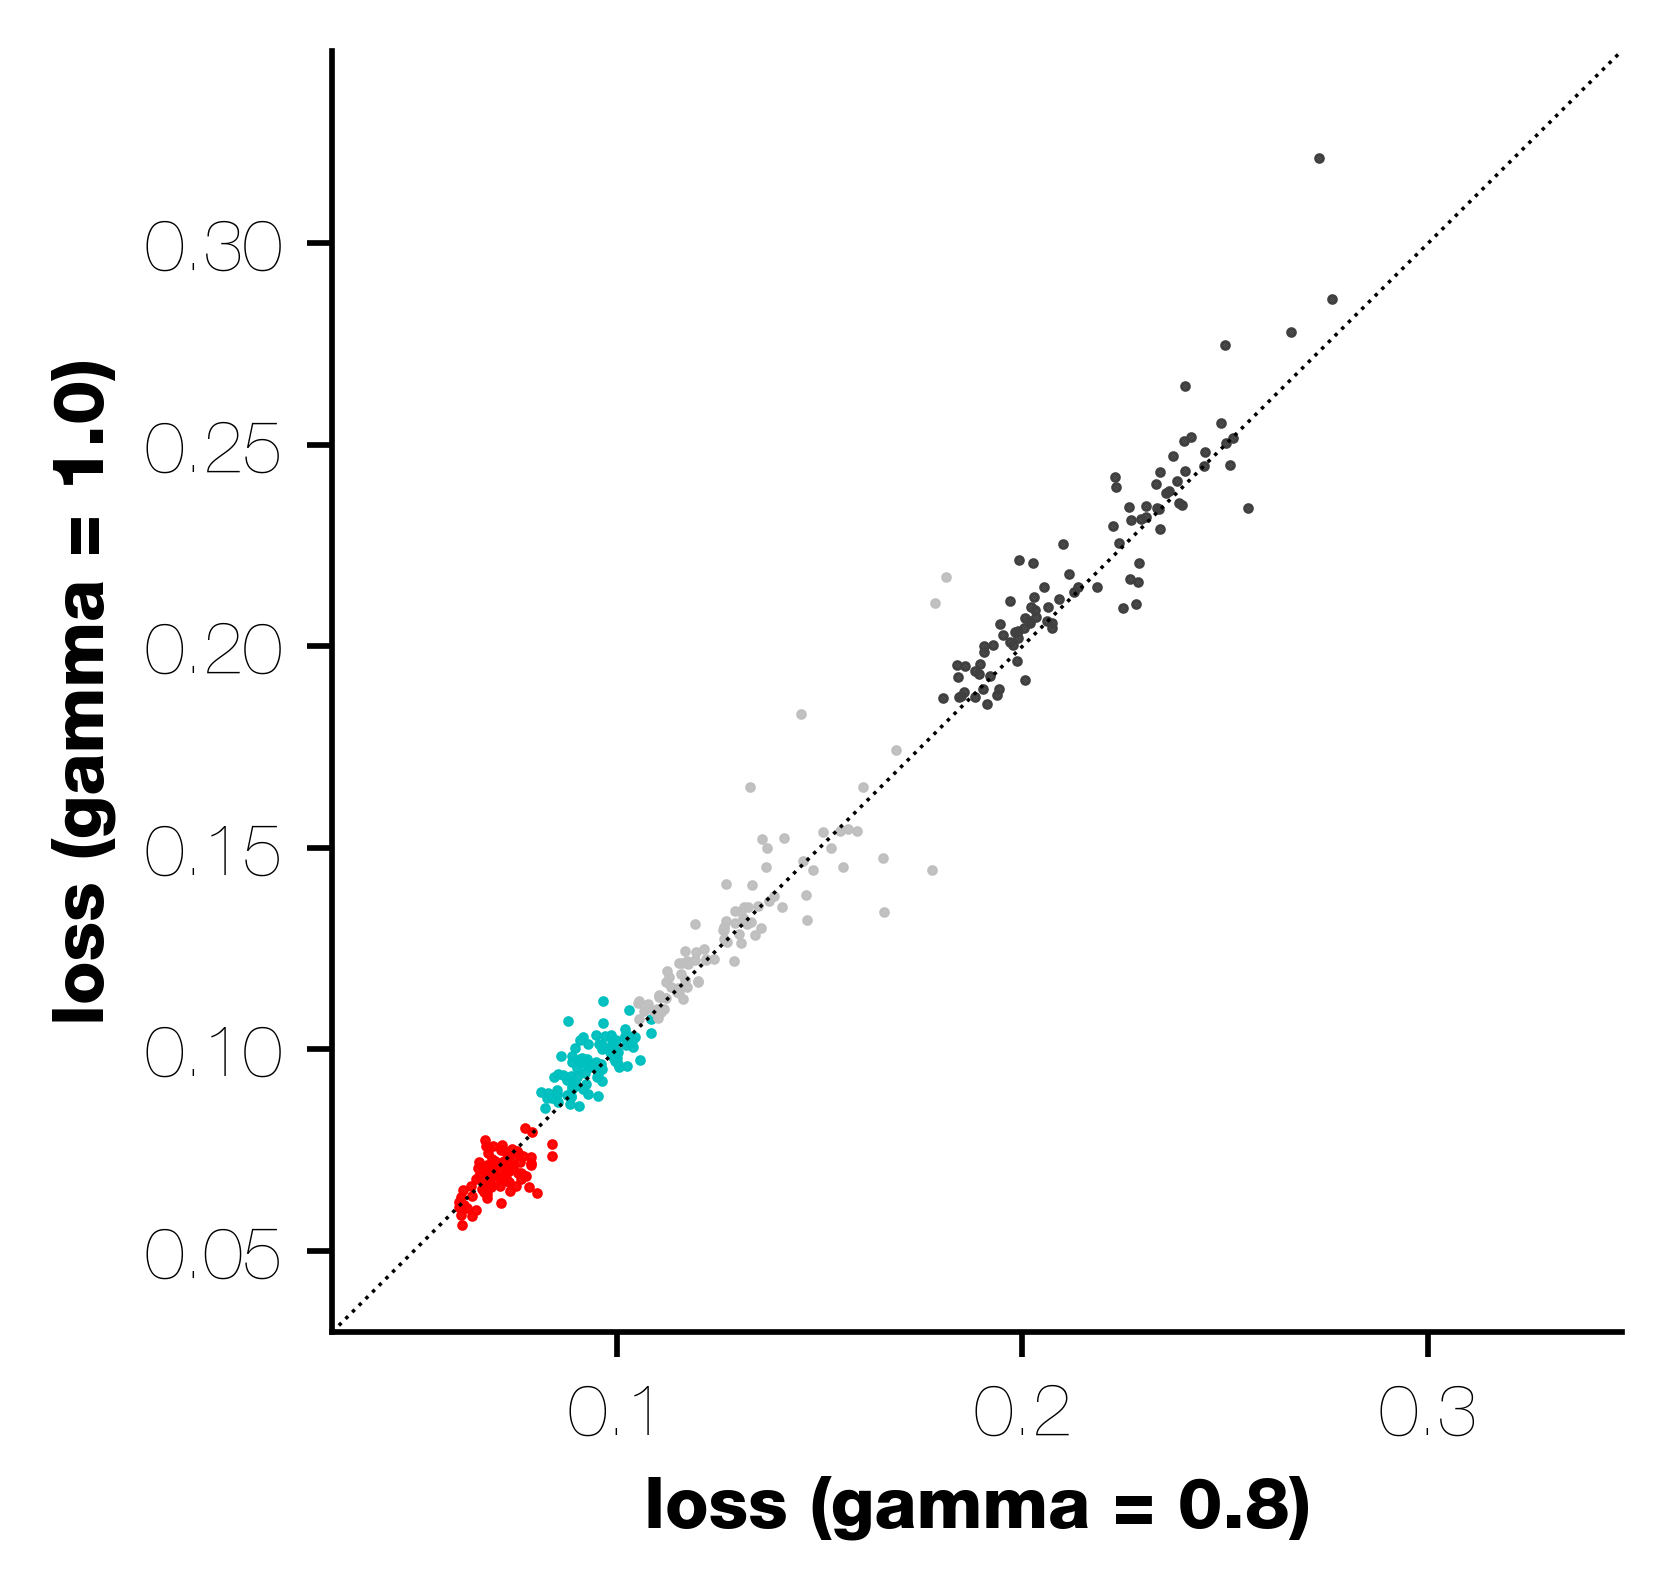

In [96]:
#(vcol, valx, valy) = ('base_model', 'resnet18', 'resnet34')
#(vcol, valx, valy) = ('batch_size', 2, 4)
#(vcol, valx, valy) = ('bce_weight', 0.67, 0.75)
#(vcol, valx, valy) = ('lr', 0.00167, 0.00844)
#(vcol, valx, valy) = ('lr', 0.00250, 0.00562)
#(vcol, valx, valy) = ('lr', 0.00167, 0.00250)
(vcol, valx, valy) = ('gamma', 0.8, 1.0)

(x1,y1) = grid_versus(cells, 'full', 'area', vcol, valx, valy)
(x2,y2) = grid_versus(cells, 'full', 'ring', vcol, valx, valy)
(x3,y3) = grid_versus(cells, 'anat', 'area', vcol, valx, valy)
(x4,y4) = grid_versus(cells, 'anat', 'ring', vcol, valx, valy)

x = np.concatenate([x1,x2,x3,x4])
y = np.concatenate([y1,y2,y3,y4])
mn = np.nanmin([x, y])
mx = np.nanmax([x, y])
rng = (mx-mn)
mx += rng/10
mn -= rng/10

(fig,ax) = plt.subplots(1,1, figsize=(3.25,3.25), dpi=512)

ax.plot(x1, y1, '.', c='r', ms=1, label='full:area')
ax.plot(x2, y2, '.', c='c', ms=1, label='full:ring')
ax.plot(x3, y3, '.', c='0.75', ms=1, label='anat:area')
ax.plot(x4, y4, '.', c='0.25', ms=1, label='anat:ring')

diffmu = np.nanmean((x - y))
diffse = np.nanstd((x - y))/np.sqrt(np.sum(np.isfinite(x + y)))
print(f'mu(x-y) = {diffmu*1000:+4.3f}e-3; se(x-y) = {diffse*1000:+4.3f}e-3')

ax.set_xlim([mn, mx])
ax.set_ylim([mn, mx])
ax.plot([mn, mx], [mn, mx], 'k:', lw=0.5)
if   vcol == 'base_model': vcol = 'model'
elif vcol == 'batch_size': vcol = 'batch size'
elif vcol == 'lr': vcol = 'learning rate'
elif vcol == 'bce_weight': vcol = 'BCE weight'
ax.set_xlabel(f'loss ({vcol} = {valx})', fontsize=10)
ax.set_ylabel(f'loss ({vcol} = {valy})', fontsize=10)
#fig.legend(loc='center right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

pass

In [90]:
def cellgrid(cells, select, col='loss_min', vmin=0, vmax=0.2, cmap='cividis'):
    # Make the four grids
    mtcs = [
        [cellselect(cells, col, inputs=ii, prediction=pp, **kw)
         for ii in ('anat', 'full')]
        for pp in ['area', 'ring']]
    # Make the plots.
    (fig,axs) = plt.subplots(
        2, 2,
        figsize=(7,7), dpi=256,
        sharex=True, sharey=True)
    fig.subplots_adjust(0,0,1,1,0.25,0.25)
    for (axrow, mtxrow) in zip(axs, mtcs):
        for (ax, mtx) in zip(axrow, mtxrow):
            hh = ax.imshow(mtx, vmin=, vmax=0.2, cmap=cmap)
    plt.colorbar(hh)
    return (fig, axs)

In [29]:
for (fmap,h) in zip(valmaps[sid], ['lh','rh']):
    trueprop = fmap.prop('A1_visual_area')
    predprop = fmap.prop('full_visual_area')
    ds = va.dice_scores(trueprop, predprop, smooth=0)
    print(f'{h}: {np.mean(ds)};  {ds}')

lh: 0.863993260769773;  [0.9341131945639085, 0.8984050688223727, 0.7594615189230378]
rh: 0.9019912693887657;  [0.934010152284264, 0.9171468309159547, 0.8548168249660787]


In [329]:
sid = 131217
surf = 'inflated'

rot = {'lh': [0,0,-np.pi/4],
       'rh': [0,0,np.pi/4]}
trl = {'lh': [-50, 0, 0],
       'rh': [50, 0, 0]}
pathdata = ny.data['hcp_lines'].native_paths['mean']

#fig = ipv.figure(width=800,height=400)

sub = valsubjects[sid]
lh = sub.lh.surface(surf).rotate(rot['lh']).translate(trl['lh'])
rh = sub.rh.surface(surf).rotate(rot['rh']).translate(trl['rh'])
fig = ny.cortex_plot(lh, figure=fig,
                     color='prf_polar_angle',
                     mask=('prf_variance_explained', 0.1, 1))
ny.cortex_plot(rh, figure=fig,
               color='prf_polar_angle',
               mask=('prf_variance_explained', 0.1, 1))

lines = {'iso_angle': ['V1_ventral','V1_dorsal',
                       'V2_ventral','V2_dorsal',
                       'V3_ventral','V3_dorsal'],
         'iso_eccen': ['7']}
for (k,lns) in lines.items():
    for ln in lns:
        for h in ['lh','rh']:
            from neuropythy.geometry.util import rotation_matrix_3D
            pdat = pathdata[sid][h][k][ln]
            xyz = pdat.coordinates[surf]
            (pitch,roll,yaw) = rot[h]
            rm = np.dot(np.dot(rotation_matrix_3D([1,0,0], pitch),
                               rotation_matrix_3D([0,1,0], roll)),
                    rotation_matrix_3D([0,0,1], yaw))
            xyz = np.dot(rm, xyz)
            xyz = xyz + np.array(trl[h])[:,None]
            (x,y,z) = xyz
            ipv.scatter(x, y, z, color='black', size=0.4)
        
#ipv.show()
fig

Figure(camera=PerspectiveCamera(fov=0.644570721372708, matrixWorldNeedsUpdate=True, position=(0.0, -100.0, 0.0…

## Notes

### Precaching Features

It can be useful to precache the feature images prior to training. This can be done using code similar to the following.

```python
# What inputs do we want to precache?
inputs = input_properties['full']
# What outputs do we want to precache?
outputs = output_properties['pred']

# Start by making datasets that use these inputs/outputs.
dsets = va.make_datasets(inputs,
                         outputs,
                         partition=(trn_sids, val_sids),
                         features=features,
                         cache_path=data_cache_path)

# This is the function we plan to run across many cores; it should be passed
# a tuple of (sid, dataset).
def precache_all(sid_ds):
    (sid, ds) = sid_ds
    # The dataset's image-cache object knows about caching.
    imcache = ds.image_cache
    # We want to cache all the data for this subject, so we loop over raters.
    for r in ('A1','A2','A3','A4'):
        # We make a target object for this rater/subject.
        targ = {'rater':r, 'subject':sid}
        if targ not in ds.targets:
            continue
        # And we ask the image-cache to precache these features.
        # Since this function will already be called in a separate process,
        # we don't need to multiprocess this request.
        imcache.precache_features(targ, inputs, multiproc=False)
    return True
```

The following code-block can then be run in a separate cell (the multiprocessing call cannot be in the same cell as the definition of the function that is being multiprocessed—in this case `precache_all`).

```python
import multiprocessing as mp

nproc = 10

trn_ds = dsets['trn']
val_ds = dsets['val']
jobs = [(sid,ds)
        for (sids,ds) in zip([trn_sids,val_sids], [trn_ds,val_ds])
        for sid in sids]
njobs = len(jobs)
for ii in range(0, njobs, nproc):
    jj = min(njobs, ii + nproc)
    nwork = jj - ii + 1
    with mp.Pool(nwork) as pool:
        pool.map(precache_all, jobs[ii:jj])
```

### Train Continuously

Here, we train the model continuously until an interruption is received (typically a keyboard interruption, which can be sent via the `Kernel > Interrupt Kernel` menu item in Jupyter. This slowly produces a lot of output, but the result, which is returned once the interrupt is sent, will be a `pandas` dataframe of training statistics.

Code to run the training for 50 cycles:

```python
model_key = '2022-05-20'
log_path = os.path.join(model_cache_path, model_key, 'training.log')
hist = train_until(training_plan,
                   until=50,
                   logger=autolog(log_path, clear=True),
                   model_key=model_key,
                   partition=(trn_sids, val_sids))
```